# Semantic Segmentation

The goal of this laboratory is to study *Semantic Segmentation* which is an image classification approach based on deep learning techniques. It involves a supervised training that is suitable when large databases with associated groundtruth are available. 

As in the last laboratory, a specific set of images is provided. It corresponds to Seismic data collected using reflection seismology. The method requires a controlled seismic source of energy, such as compressed air or a seismic vibrator, and sensors record the reflection from rock interfaces within the subsurface. Reflection seismology is similar to X-ray, sonar and echolocation. The seismic image shows the boundaries between different rock types. In theory, the strength of reflection is directly proportional to the difference in the physical properties on either side of the interface. 

The oil prospection industry uses seismic images to understand which areas beneath the Earth’s surface may contain large amounts of oil and gas. Interestingly, the surfaces which contain oil and gas, also contain huge deposits of salt. It is important in petroleum geology because salt structures are impermeable and can lead to the formation of a stratigraphic trap or salt dome.
 

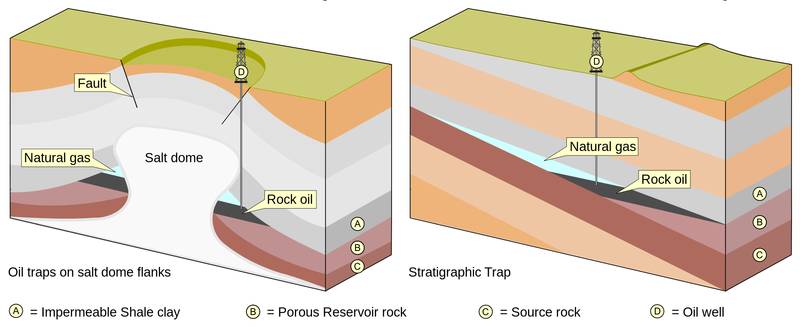

So, with the help of seismic technology, an important goal is to try to predict which areas in the surface of the Earth contain huge amount of salts. Unfortunately, seismic imaging requires expert human vision to exactly identify salt bodies. This leads to highly subjective and variable renderings. Moreover it could cause potentially dangerous situations and huge loss for the oil and gas company drillers if the human prediction is incorrect. So, in this laboratory, we will study whether semantic segmentation is able to build an algorithm that automatically and accurately identifies if a subsurface target is salt or not.

## 1 Lab configuration

Upload the "images.zip" and "masks.zip" files in the session storage (using the "Files" and "Upload" options on the upper left part of the browser). The Archives contains the image and mask material corresponding to this lab.

#### Initialization
Let us import the necessary library. Note that we will work with pytorch to implement the semantic segmentation algorithm. 

In [3]:
!pip install torchsummary

In [4]:
import os
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import math
import random
#import pandas as pd
import numpy as np
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm, notebook
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms, utils
from torchsummary import summary

Make sure that you are using the colaboratory GPU (and not the CPU)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


#### Load the dataset
Let us unzip the dataset of images. 

In [7]:
!pip install unzip

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for unzip: filename=unzip-1.0.0-py3-none-any.whl size=1287 sha256=51b8b020bd1c4db5c175a3bef15c1f8e9097ff2b2c518e940f26ba1484043151
  Stored in directory: c:\users\amola\appdata\local\pip\cache\wheels\5a\3d\8a\1ff7948c2e5c4ba8032812825fa2d4bb86e5ba92f2b07677ea
Successfully built unzip


In [6]:
# Uncompress the database
#!unzip -q images.zip
#!unzip -q masks.zip

# Set some parameters
im_width = 128
im_height = 128
border = 5

Check that you indeed have access to the images. The number of images in the database should be 4.000. 

In [7]:
ids = next(os.walk("images"))[2] # list of names all images in the given path
print("No. of images in the dataset = ", len(ids))

No. of images in the dataset =  4000


Load the images in python variables.  

In [8]:
X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

# tqdm is used to display the progress bar
for n, id_ in notebook.tqdm(enumerate(ids), total=len(ids)):
    # Load images
    x_img = imread("images/"+id_, as_gray=True)
    x_img = resize(x_img, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Load masks
    mask = imread("masks/"+id_, as_gray=True)
    mask = resize(mask, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Save images
    X[n] = x_img/255.0
    y[n] = mask/255.0

  0%|          | 0/4000 [00:00<?, ?it/s]

Let us split the database in training set (90%) and validation set (10%). 

In [9]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

# Pytorch tensors
X_train_T = torch.Tensor(X_train).permute(0,3,1,2)
y_train_T = torch.squeeze(torch.Tensor(y_train).permute(0,3,1,2),1)
y_train_T = np.clip(y_train_T.long(),0,1)

X_valid_T = torch.Tensor(X_valid).permute(0,3,1,2)
y_valid_T = torch.squeeze(torch.Tensor(y_valid).permute(0,3,1,2),1)
y_valid_T = np.clip(y_valid_T.long(),0,1)

valid     = X_valid_T.numpy()
gt_valid  = y_valid_T.numpy()

Finally, let us visualize random images for the database as well as their associated groundtruth mask defining salt deposit. 

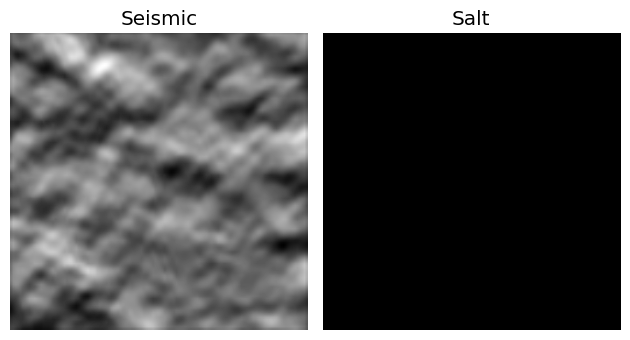

In [13]:
# Visualize random images along with their mask
ix = random.randint(0, len(X_train))
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(X_train[ix, ..., 0], cmap = 'gray', interpolation = 'bilinear')
ax1.set_title('Seismic')
ax1.axis('off')

ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Salt')
ax2.axis('off')
fig.tight_layout()

As you can see, the identification of salt deposit is not a trivial task!

## 2 Analysis of upsampling
During the course, we have seen that one of the distinctive features of the semantic segmentation is the upsampling process. We have discussed several approaches that can be used in the context of CNN. Here we will experiment with two of them: *Upsampling* and *Transposed convolution*. 

<font color='purple'> Analyze the following code. An arbitrary tensor is created and then downsampled by a MaxPooling step. Then two upsampling strategies are proposed. In each case, some of the parameters are not defined. They are marked by ??? and your task is to specify the parameters so that the final tensors out1 and out2 have the same size as the original input tensor.  
</font>



In [11]:
# Create a random tensor 
input = torch.randn(1, 4, 128, 128)

# Downsampling
downsample = nn.MaxPool2d(kernel_size=2,stride=2)
h = downsample(input)

# Upsampling 1: Upsampling and convolution
upsample1 = nn.Upsample(scale_factor=2)
conv1     = nn.Conv2d(in_channels=4,out_channels=4,kernel_size=3,stride=1,padding=1,bias=True)
up1  = upsample1(h)
out1 = conv1(up1)

# Upsampling 2: Transposed convolution
upsample2 = nn.ConvTranspose2d(in_channels=4,out_channels=4,kernel_size=4,stride=2,padding=1,bias=True)
out2 = upsample2(h)

print('Original Tensor: ', input.shape, 'Downsampled tensor: ', h.shape)
print('Upsampling: ', up1.shape, 'Convolution: ',  out1.shape)
print('Transposed Convolution: ', out2.shape)

Original Tensor:  torch.Size([1, 4, 128, 128]) Downsampled tensor:  torch.Size([1, 4, 64, 64])
Upsampling:  torch.Size([1, 4, 128, 128]) Convolution:  torch.Size([1, 4, 128, 128])
Transposed Convolution:  torch.Size([1, 4, 128, 128])


**Per al primer cas:**

**Sabem que si a una imatge de mida N x N i apliquem un padding de mida P, amb un stride de mida S i un filtre de mida F x F, la imatge resultant esdevé de mdia:**

$$M' = \frac{N - F + 2P}{S} + 1$$

**Originalment, tenim una imatge de mida 128 x 128 i hi apliquem un MaxPooling, amb la qual cosa passem a tenir una imatge de mida 64 x 64. Posteriorment, hi apliquem un Upsampling de factor 2, per tant, tornem a obtenir una imatge de mida 128 x 128. Per tant, la nostra equació esdevé:**

$$128 = \frac{128 - 3 + 2}{S} + 1$$

$$128 = \frac{127}{S} + 1$$

$$127 = \frac{127}{S}$$

$$S = 1$$

**Per al segon cas:**

**Sabem que si a una imatge de mida N x N i apliquem un padding de mida P, amb un stride de mida S i un filtre de mida F x F, la imatge resultant esdevé de mida:**

$$M' = (N - 1)\cdot S - 2\cdot P + F$$

**Originalment, tenim una imatge de mida 128 x 128 i hi apliquem un MaxPooling, amb la qual cosa passem a tenir una imatge de mida 64 x 64.**

$$128 = (64 - 1)\cdot S - 2\cdot 1 + F - 1 + 1$$

$$128 = (64 - 1)\cdot S - 2 + F$$

$$130 = (64 - 1)\cdot S + F$$

$$130 = (63)\cdot S + F$$

**Per tant, provant valors típics d'aquests paràmetres, podem veure com:**

$$S = 2$$

$$F = 4$$

### Upsampling and Convolution
In order to get some intuition on the first upsampling strategy, the one involving simple upsampling followed by a convolution, we are going to define a toy neural network example. 

The encoding part of the network, that is the part that decreases the resolution, involves a convolution (`Conv1`), a batch normalization (`BatchNorm1`), a ReLu (`ReLu`) and a max pooling (`Maxpool`).

The decoding part increases the resolution and is composed of an upsampling (`Upsample`), a convolution (`Conv2`), a batch normalization (`BatchNorm1`), a ReLu (`ReLu`) and a final convolution (`Conv_1x1`).

<font color='purple'> The `Conv2` layer is not fully specified. Finalize its specification by using the result of the previous section.   
</font>

In [35]:
class Simple_Net_UpSample(nn.Module):
    def __init__(self,input_ch=1,output_ch=1):
        super(Simple_Net_UpSample,self).__init__()
        self.ReLu       = nn.ReLU()
        self.Maxpool    = nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.Conv1      = nn.Conv2d(in_channels=1,out_channels=4,kernel_size=3,stride=1,padding=1,bias=True)
        self.BatchNorm1 = nn.BatchNorm2d(num_features=4,track_running_stats=False)
        self.Upsample   = nn.Upsample(scale_factor=2)
        self.Conv2      = nn.Conv2d(in_channels=4,out_channels=4,kernel_size=3,stride=1,padding=1,bias=True)
        self.BatchNorm2 = nn.BatchNorm2d(num_features=4,track_running_stats=False)
        
        self.Conv_1x1   = nn.Conv2d(in_channels=4,out_channels=output_ch,kernel_size=1,stride=1,padding=0)

    def forward(self,x):
        # Encoding path
        x1 = self.Conv1(x)
        x1 = self.BatchNorm1(x1)
        x1 = self.ReLu(x1)
        x1 = self.Maxpool(x1)
        
        # Decoding path
        x2 = self.Upsample(x1)
        x2 = self.Conv2(x2)
        
        x3 = self.BatchNorm1(x2)
        x3 = self.ReLu(x3)
        x4 = self.Conv_1x1(x3)

        return x4

Let us create the pytorch model and load it in the GPU.

In [36]:
model = Simple_Net_UpSample(output_ch=2)
model.to(device)

Simple_Net_UpSample(
  (ReLu): ReLU()
  (Maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (BatchNorm1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (Upsample): Upsample(scale_factor=2.0, mode='nearest')
  (Conv2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (BatchNorm2): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (Conv_1x1): Conv2d(4, 2, kernel_size=(1, 1), stride=(1, 1))
)

Let us check the composition of the model. 

In [37]:
summary(model, (1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 128, 128]              40
       BatchNorm2d-2          [-1, 4, 128, 128]               8
              ReLU-3          [-1, 4, 128, 128]               0
         MaxPool2d-4            [-1, 4, 64, 64]               0
          Upsample-5          [-1, 4, 128, 128]               0
            Conv2d-6          [-1, 4, 128, 128]             148
       BatchNorm2d-7          [-1, 4, 128, 128]               8
              ReLU-8          [-1, 4, 128, 128]               0
            Conv2d-9          [-1, 2, 128, 128]              10
Total params: 214
Trainable params: 214
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.06
Forward/backward pass size (MB): 3.88
Params size (MB): 0.00
Estimated Total Size (MB): 3.94
---------------------------------------------------

Finally, let us specify the training loss and optimizer.

In [ ]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-3 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
best_valid_F1 = 0

As this model is extremely simple, it will not provide interesting results in terms of classification. We will any way run some training steps to check that everything is correct and the training actually allows to decrease the loss. It is also an opportunity to build a training loop that will be used later on more complex models. 

<font color='purple'> First analyze the code to understand the various steps. Then, run the training for 4 Epochs.   
</font>

In [39]:
NEpoch = 4;    # Number of Epoch
MBsize = 32;   # Minibatch size
model.train()

it = 0
# Loop on Epoch
for t in notebook.tqdm(range(NEpoch), desc='Epoch: '):
  model.train()
  idx = torch.randperm(y_train_T.size()[0])
  X_train_T = X_train_T[idx]
  y_train_T = y_train_T[idx]
  
  running_loss = 0
  running_accu = 0
  running_TP, running_P, running_T   = 0.0, 0.0, 0.0

  # Loop on minibatch
  for n in notebook.tqdm(range(math.floor(y_train_T.shape[0]/MBsize)), desc='MiniBatch: '):
    X_train_TMB = X_train_T[n*MBsize:(n+1)*MBsize,:,:,:]
    y_train_TMB = y_train_T[n*MBsize:(n+1)*MBsize,:,:]
    X_train_TMB, y_train_TMB = X_train_TMB.to(device), y_train_TMB.to(device)
    
    # Forward pass: compute predicted y by passing x to the model.
    y_pred_TMB = model(X_train_TMB)

    # Compute the loss.
    loss = loss_fn(y_pred_TMB, y_train_TMB)
    running_loss += loss
    
    # Compute accuracy, Precision and recall
    pred    = y_pred_TMB.cpu().detach().numpy()
    pred_th = (pred[:,1,:,:]>0.5).astype(float)
    gt      = y_train_TMB.cpu().numpy()
    running_accu += (pred_th == gt).sum()/gt.size
    running_TP += ((pred_th+gt)==2).sum()
    running_P  += pred_th.sum()
    running_T  += gt.sum()
    
    # Display the loss and F1
    if n % math.floor(y_train_T.shape[0]/MBsize/5) == 0: 
      precision = running_TP/(running_P+1e-6)
      recall    = running_TP/(running_T+1e-6)
      F1        = 2*precision*recall/(precision+recall+1e-6)
      print("Epoch{0:3d}/MiniBatch{1:4d}, MB.Loss {2:1.3f}, Av.Loss {3:1.3f}, Av.F1 {4:1.3f}"\
            .format(t+1, n+1, loss.item(), running_loss/(n+1), F1))

    # Clear the past gradients and compute new gradient
    optimizer.zero_grad()
    loss.backward()

    # Update of parameters
    optimizer.step()

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch  1/MiniBatch   1, MB.Loss 1.074, Av.Loss 1.074, Av.F1 0.232
Epoch  1/MiniBatch  23, MB.Loss 0.936, Av.Loss 1.011, Av.F1 0.125
Epoch  1/MiniBatch  45, MB.Loss 0.914, Av.Loss 0.972, Av.F1 0.090
Epoch  1/MiniBatch  67, MB.Loss 0.882, Av.Loss 0.941, Av.F1 0.074
Epoch  1/MiniBatch  89, MB.Loss 0.780, Av.Loss 0.915, Av.F1 0.062
Epoch  1/MiniBatch 111, MB.Loss 0.789, Av.Loss 0.891, Av.F1 0.054


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch  2/MiniBatch   1, MB.Loss 0.781, Av.Loss 0.781, Av.F1 0.012
Epoch  2/MiniBatch  23, MB.Loss 0.740, Av.Loss 0.755, Av.F1 0.005
Epoch  2/MiniBatch  45, MB.Loss 0.714, Av.Loss 0.741, Av.F1 0.003
Epoch  2/MiniBatch  67, MB.Loss 0.695, Av.Loss 0.730, Av.F1 0.002
Epoch  2/MiniBatch  89, MB.Loss 0.674, Av.Loss 0.719, Av.F1 0.002
Epoch  2/MiniBatch 111, MB.Loss 0.680, Av.Loss 0.710, Av.F1 0.001


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch  3/MiniBatch   1, MB.Loss 0.670, Av.Loss 0.670, Av.F1 0.000
Epoch  3/MiniBatch  23, MB.Loss 0.640, Av.Loss 0.655, Av.F1 0.000
Epoch  3/MiniBatch  45, MB.Loss 0.629, Av.Loss 0.653, Av.F1 0.000
Epoch  3/MiniBatch  67, MB.Loss 0.641, Av.Loss 0.650, Av.F1 0.000
Epoch  3/MiniBatch  89, MB.Loss 0.638, Av.Loss 0.645, Av.F1 0.000
Epoch  3/MiniBatch 111, MB.Loss 0.650, Av.Loss 0.640, Av.F1 0.000


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch  4/MiniBatch   1, MB.Loss 0.668, Av.Loss 0.668, Av.F1 0.000
Epoch  4/MiniBatch  23, MB.Loss 0.626, Av.Loss 0.619, Av.F1 0.000
Epoch  4/MiniBatch  45, MB.Loss 0.628, Av.Loss 0.616, Av.F1 0.000
Epoch  4/MiniBatch  67, MB.Loss 0.646, Av.Loss 0.613, Av.F1 0.000
Epoch  4/MiniBatch  89, MB.Loss 0.577, Av.Loss 0.609, Av.F1 0.000
Epoch  4/MiniBatch 111, MB.Loss 0.620, Av.Loss 0.608, Av.F1 0.000


You should see that the average loss (Av.Loss) is decreasing. The F1 value may be very low (even equal to 0) as the model is not really appropriate for the task.

Now we are going to have a look at the activations along the model. For that we need to define `hook` functions (In pytorch, `hooks` are functions that are executed when a call is executed) as well as a specific visualization function to handle activations with multiple channels. 

In [53]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

def get_pre_activation(name):
    def hook(model, input):
        activation[name] = input
    return hook
  
def custom_viz(kernels, path=None, columns=8):  
  N = kernels.shape[0]
  C = kernels.shape[1]
  P = kernels.shape[2]
  Tot = N*C

  rows = Tot // columns 
  rows += Tot % columns
  pos  = range(1,Tot + 1)

  fig = plt.figure(1)
  #fig.tight_layout()
  k=0
  for i in range(kernels.shape[0]):
    for j in range(kernels.shape[1]):
      img = kernels[i][j]
      ax = fig.add_subplot(rows,columns,pos[k])
      ax.imshow(img, cmap='gray')
      plt.axis('off')
      k = k+1

  ax.figure.set_size_inches(4*columns*P/100, 4*rows*P/100)
  
  if path:
    plt.savefig(path)
    
  plt.show()

Then, we register the hooks on specific layers of the model. These hooks are executed after the function is called. Therefore, they allow us to see the activations at the output of the layer. The names appearing in the hooks refer to the layers of the summary used above (`summary(model, (1, 128, 128))`)

In [ ]:
model.Conv1.register_forward_hook(get_activation('Conv2d-1'))
model.Maxpool.register_forward_hook(get_activation('MaxPool2d-4'))
model.Upsample.register_forward_hook(get_activation('Upsample-5'))
model.Conv2.register_forward_hook(get_activation('Conv2d-6'))
model.Conv_1x1.register_forward_hook(get_activation('Conv2d-8'))

Let us choose a specific input image of the training set and display it together with its corresponding mask. 

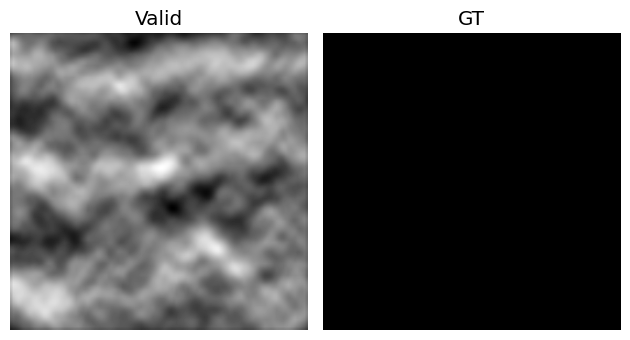

In [42]:
# Number of the training set image 
ima = 13
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(valid[ima,0,:,:], cmap = 'gray', interpolation = 'bilinear')
ax1.set_title('Valid')
ax1.axis('off')
ax2.imshow(gt_valid[ima,:,:], cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('GT')
ax2.axis('off')
fig.tight_layout()

Finally, we run the image through the model and display the activations on all layers having a hook. 

Layer: Conv2d-1 torch.Size([1, 4, 128, 128])


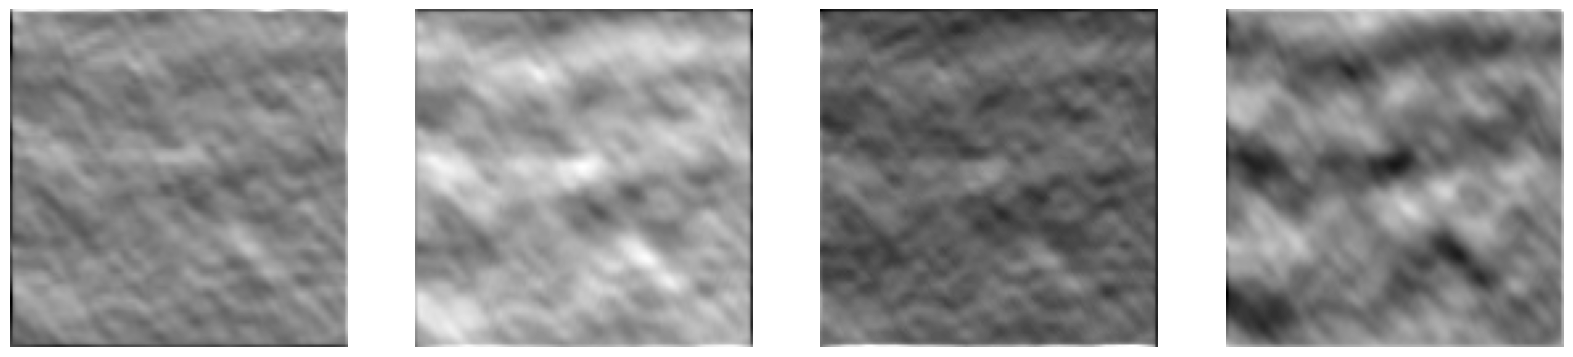

Layer: MaxPool2d-4 torch.Size([1, 4, 64, 64])


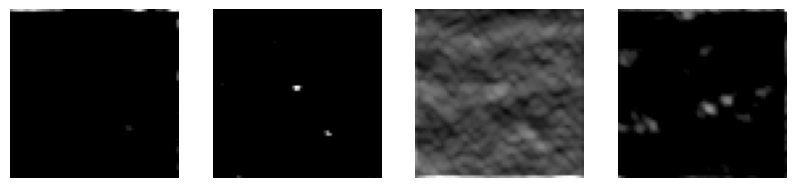

Layer: Upsample-5 torch.Size([1, 4, 128, 128])


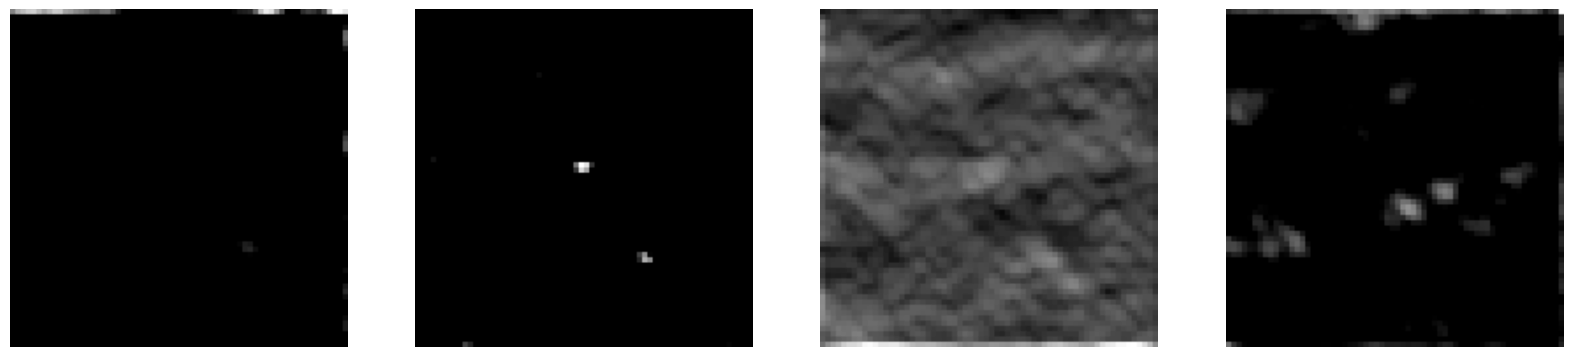

Layer: Conv2d-6 torch.Size([1, 4, 128, 128])


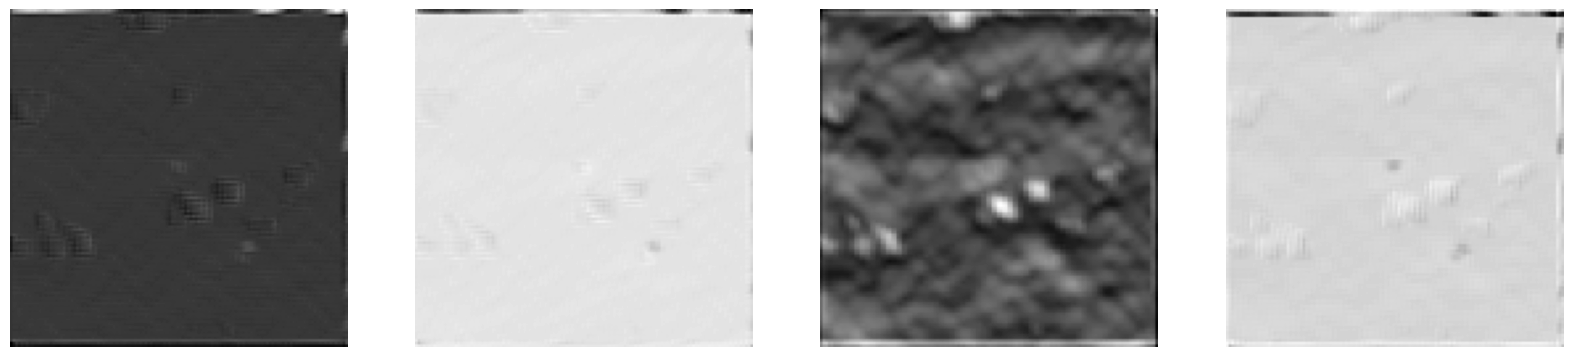

Layer: Conv2d-8 torch.Size([1, 2, 128, 128])


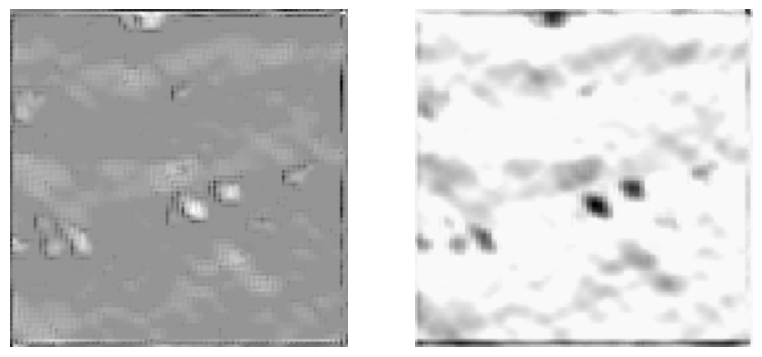

In [43]:
prediction = model(X_valid_T[ima:ima+1,:,:,:].to(device))

hook_name = 'Conv2d-1'
print('Layer: ' + hook_name, activation[hook_name].shape)
custom_viz(activation[hook_name].cpu().detach().clone(), hook_name + '.png',8)

hook_name = 'MaxPool2d-4'
print('Layer: ' + hook_name, activation[hook_name].shape)
custom_viz(activation[hook_name].cpu().detach().clone(), hook_name + '.png',8)

hook_name = 'Upsample-5'
print('Layer: ' + hook_name, activation[hook_name].shape)
custom_viz(activation[hook_name].cpu().detach().clone(), hook_name + '.png',8)

hook_name = 'Conv2d-6'
print('Layer: ' + hook_name, activation[hook_name].shape)
custom_viz(activation[hook_name].cpu().detach().clone(), hook_name + '.png',8)

hook_name = 'Conv2d-8'
print('Layer: ' + hook_name, activation[hook_name].shape)
custom_viz(activation[hook_name].cpu().detach().clone(), hook_name + '.png',8)

### Transposed Convolution
Now, we are going to make a similar experiment with a transposed convolution instead of Upsampling & Convolution. Let us define the model.

<font color='purple'> The `ConvTr1` layer is not fully specified. Finalize its specification by using the result of the work previously done.   
</font>

In [64]:
class Simple_Net_TrConv(nn.Module):
    def __init__(self,input_ch=1,output_ch=1):
        super(Simple_Net_TrConv,self).__init__()
        self.ReLu       = nn.ReLU()
        self.Maxpool    = nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.Conv1      = nn.Conv2d(in_channels=1,out_channels=4,kernel_size=3,stride=1,padding=1,bias=True)
        self.BatchNorm1 = nn.BatchNorm2d(num_features=4,track_running_stats=False)
        self.ConvTr1    = nn.ConvTranspose2d(in_channels=4,out_channels=4,kernel_size=4,stride=2,padding=1,bias=True)
        self.BatchNorm2 = nn.BatchNorm2d(num_features=4,track_running_stats=False)
        
        self.Conv_1x1   = nn.Conv2d(in_channels=4,out_channels=output_ch,kernel_size=1,stride=1,padding=0)

    def forward(self,x):
        # Encoding path
        x1 = self.Conv1(x)
        x1 = self.BatchNorm1(x1)
        x1 = self.ReLu(x1)
        x1 = self.Maxpool(x1)
        
        # Decoding path
        x2 = self.ConvTr1(x1)
        
        x3 = self.BatchNorm1(x2)
        x3 = self.ReLu(x3)
        x4 = self.Conv_1x1(x3)

        return x4

Model definition

In [56]:
model = Simple_Net_TrConv(output_ch=2)
model.to(device)

Simple_Net_TrConv(
  (ReLu): ReLU()
  (Maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (BatchNorm1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (ConvTr1): ConvTranspose2d(4, 4, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (BatchNorm2): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (Conv_1x1): Conv2d(4, 2, kernel_size=(1, 1), stride=(1, 1))
)

In [57]:
summary(model, (1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 128, 128]              40
       BatchNorm2d-2          [-1, 4, 128, 128]               8
              ReLU-3          [-1, 4, 128, 128]               0
         MaxPool2d-4            [-1, 4, 64, 64]               0
   ConvTranspose2d-5          [-1, 4, 128, 128]             260
       BatchNorm2d-6          [-1, 4, 128, 128]               8
              ReLU-7          [-1, 4, 128, 128]               0
            Conv2d-8          [-1, 2, 128, 128]              10
Total params: 326
Trainable params: 326
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.06
Forward/backward pass size (MB): 3.38
Params size (MB): 0.00
Estimated Total Size (MB): 3.44
----------------------------------------------------------------


In [58]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-3 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
best_valid_F1 = 0

In [59]:
NEpoch = 4;   # Number of Epoch
MBsize = 32;   # Minibatch size
model.train()

it = 0
# Loop on Epoch
for t in notebook.tqdm(range(NEpoch), desc='Epoch: '):
  model.train()
  idx = torch.randperm(y_train_T.size()[0])
  X_train_T = X_train_T[idx]
  y_train_T = y_train_T[idx]
  
  running_loss = 0
  running_accu = 0
  running_TP, running_P, running_T   = 0.0, 0.0, 0.0

  # Loop on Minibach
  for n in notebook.tqdm(range(math.floor(y_train_T.shape[0]/MBsize)), desc='MiniBatch: '):
    X_train_TMB = X_train_T[n*MBsize:(n+1)*MBsize,:,:,:]
    y_train_TMB = y_train_T[n*MBsize:(n+1)*MBsize,:,:]
    X_train_TMB, y_train_TMB = X_train_TMB.to(device), y_train_TMB.to(device)
    
    # Forward pass: compute predicted y by passing x to the model.
    y_pred_TMB = model(X_train_TMB)

    # Compute the loss.
    loss = loss_fn(y_pred_TMB, y_train_TMB)
    running_loss += loss
    
    # Compute accuracy, Precision and recall
    pred    = y_pred_TMB.cpu().detach().numpy()
    pred_th = (pred[:,1,:,:]>0.5).astype(float)
    gt      = y_train_TMB.cpu().numpy()
    running_accu += (pred_th == gt).sum()/gt.size
    running_TP += ((pred_th+gt)==2).sum()
    running_P  += pred_th.sum()
    running_T  += gt.sum()
    
    # Display the loss and F1
    if n % math.floor(y_train_T.shape[0]/MBsize/5) == 0: 
      precision = running_TP/(running_P+1e-6)
      recall    = running_TP/(running_T+1e-6)
      F1        = 2*precision*recall/(precision+recall+1e-6)
      print("Epoch{0:3d}/MiniBatch{1:4d}, MB.Loss {2:1.3f}, Av.Loss {3:1.3f}, Av.F1 {4:1.3f}"\
            .format(t+1, n+1, loss.item(), running_loss/(n+1), F1))

    # Clear the past gradients and compute new gradient
    optimizer.zero_grad()
    loss.backward()

    # Update of parameters
    optimizer.step()

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch  1/MiniBatch   1, MB.Loss 1.081, Av.Loss 1.081, Av.F1 0.409
Epoch  1/MiniBatch  23, MB.Loss 1.046, Av.Loss 1.034, Av.F1 0.356
Epoch  1/MiniBatch  45, MB.Loss 0.897, Av.Loss 0.996, Av.F1 0.314
Epoch  1/MiniBatch  67, MB.Loss 0.767, Av.Loss 0.964, Av.F1 0.266
Epoch  1/MiniBatch  89, MB.Loss 0.878, Av.Loss 0.939, Av.F1 0.229
Epoch  1/MiniBatch 111, MB.Loss 0.810, Av.Loss 0.916, Av.F1 0.200


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch  2/MiniBatch   1, MB.Loss 0.811, Av.Loss 0.811, Av.F1 0.002
Epoch  2/MiniBatch  23, MB.Loss 0.758, Av.Loss 0.783, Av.F1 0.000
Epoch  2/MiniBatch  45, MB.Loss 0.739, Av.Loss 0.769, Av.F1 0.000
Epoch  2/MiniBatch  67, MB.Loss 0.705, Av.Loss 0.755, Av.F1 0.000
Epoch  2/MiniBatch  89, MB.Loss 0.688, Av.Loss 0.742, Av.F1 0.000
Epoch  2/MiniBatch 111, MB.Loss 0.675, Av.Loss 0.728, Av.F1 0.000


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch  3/MiniBatch   1, MB.Loss 0.656, Av.Loss 0.656, Av.F1 0.000
Epoch  3/MiniBatch  23, MB.Loss 0.626, Av.Loss 0.652, Av.F1 0.000
Epoch  3/MiniBatch  45, MB.Loss 0.615, Av.Loss 0.640, Av.F1 0.000
Epoch  3/MiniBatch  67, MB.Loss 0.581, Av.Loss 0.628, Av.F1 0.000
Epoch  3/MiniBatch  89, MB.Loss 0.570, Av.Loss 0.623, Av.F1 0.000
Epoch  3/MiniBatch 111, MB.Loss 0.556, Av.Loss 0.616, Av.F1 0.000


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch  4/MiniBatch   1, MB.Loss 0.506, Av.Loss 0.506, Av.F1 0.000
Epoch  4/MiniBatch  23, MB.Loss 0.533, Av.Loss 0.568, Av.F1 0.000
Epoch  4/MiniBatch  45, MB.Loss 0.554, Av.Loss 0.570, Av.F1 0.000
Epoch  4/MiniBatch  67, MB.Loss 0.614, Av.Loss 0.572, Av.F1 0.000
Epoch  4/MiniBatch  89, MB.Loss 0.464, Av.Loss 0.570, Av.F1 0.000
Epoch  4/MiniBatch 111, MB.Loss 0.601, Av.Loss 0.569, Av.F1 0.000


Let us register the `Hooks` on various layers. 

In [60]:
model.Conv1.register_forward_hook(get_activation('Conv2d-1'))
model.Maxpool.register_forward_hook(get_activation('MaxPool2d-4'))
model.ConvTr1.register_forward_hook(get_activation('ConvTranspose2d-5'))
model.Conv_1x1.register_forward_hook(get_activation('Conv2d-8'))

Finally, let us visualize the activations. 

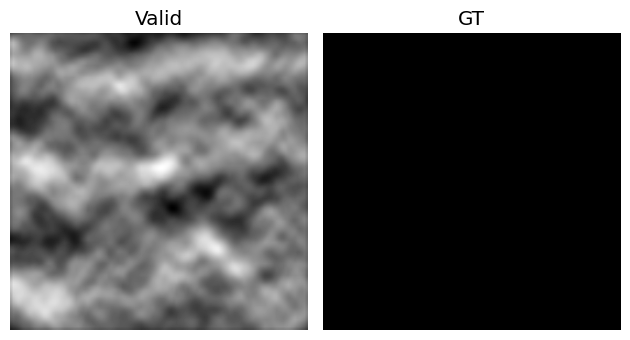

In [61]:
ima = 13
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(valid[ima,0,:,:], cmap = 'gray', interpolation = 'bilinear')
ax1.set_title('Valid')
ax1.axis('off')
ax2.imshow(gt_valid[ima,:,:], cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('GT')
ax2.axis('off')
fig.tight_layout()

Conv2d-1 torch.Size([1, 4, 128, 128])


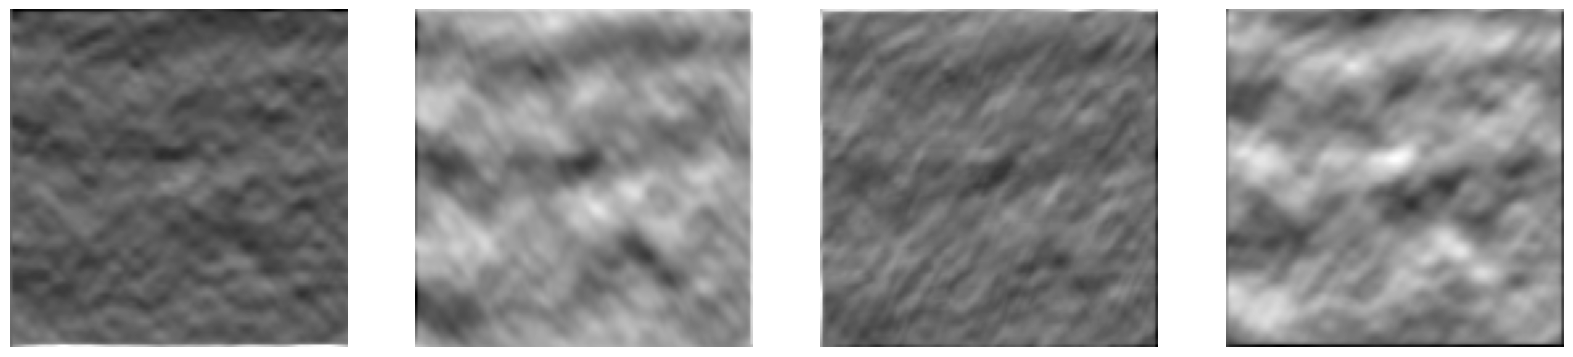

MaxPool2d-4 torch.Size([1, 4, 64, 64])


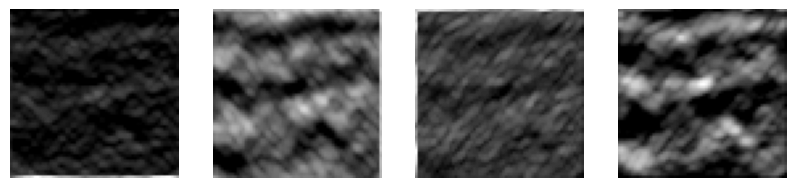

ConvTranspose2d-5 torch.Size([1, 4, 128, 128])


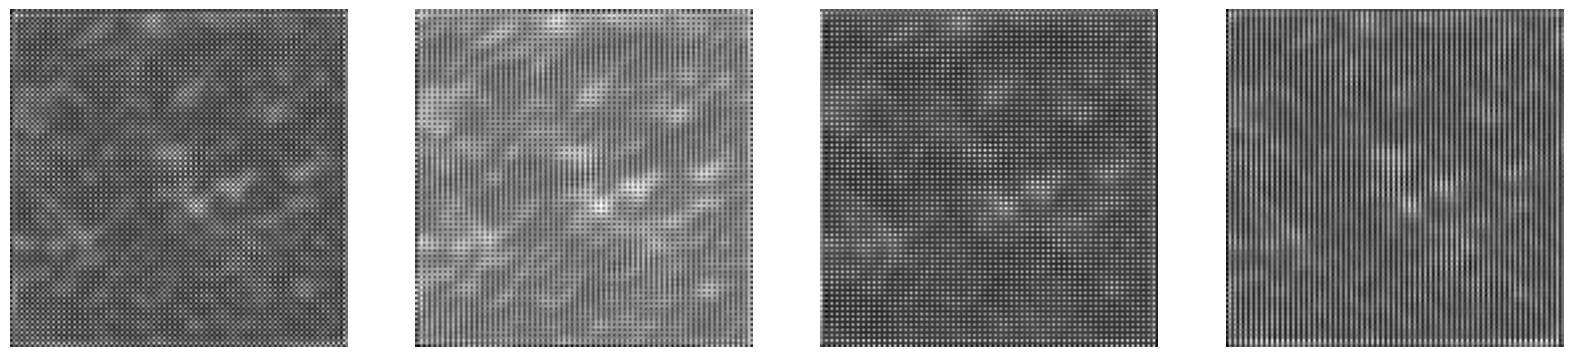

Conv2d-8 torch.Size([1, 2, 128, 128])


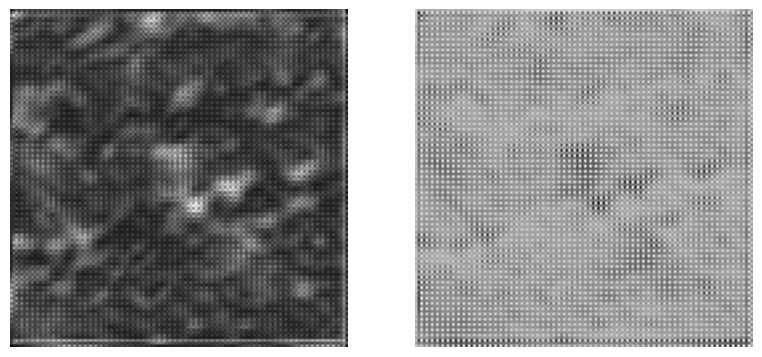

In [52]:
prediction = model(X_valid_T[ima:ima+1,:,:,:].to(device))

hook_name = 'Conv2d-1'
print(hook_name, activation[hook_name].shape)
custom_viz(activation[hook_name].cpu().detach().clone(), hook_name + '.png',8)

hook_name = 'MaxPool2d-4'
print(hook_name, activation[hook_name].shape)
custom_viz(activation[hook_name].cpu().detach().clone(), hook_name + '.png',8)

hook_name = 'ConvTranspose2d-5'
print(hook_name, activation[hook_name].shape)
custom_viz(activation[hook_name].cpu().detach().clone(), hook_name + '.png',8)

hook_name = 'Conv2d-8'
print(hook_name, activation[hook_name].shape)
custom_viz(activation[hook_name].cpu().detach().clone(), hook_name + '.png',8)

<font color='purple'> It is difficult to judge the quality of the resulting upsampling processes as the models are very simple, not appropriate for the task and severely undertrained. Anyway, what can be said about their differences (Hint: Take also into consideration the information provided by the `summary`): </font>


**Tenint en compte la complexitat d'ambdos models i el temps d'entrenament, no és que es pugui realment extreure una bona conclusió. Però, podem extreure'n algunes idees. Hem pogut veure com el Net_Up té un upsampling, que no afegeix nous paràmetres (així ho hem pogut veure en el summary del model, on podem veure com en total compta amb 214 paràmetres). La loss d'aquest model és més alta que el segon model i en les imatges de les activacions, hem pogut veure com les característiques que extreu no són del tot bones en comparació al segon.**

**En el model Net_Tr en canvi, en usar una transposed convolution, té una sèrie de paràmetres nous que aprén per tal de donar valor als píxels nous. El summary del model ens diu que té 326 paràmetres, un nombre superior al primer. Podem veure com la seva loss és més baixa i a més, les imatges de les activacions són més interpretables i ens proporcionen una millor informació.**

## 3 Network inspired by the *UNet*
In this section, we are going to create two networks inspired by the UNet model. This model is based on an encoder / decoder architecture. 
 

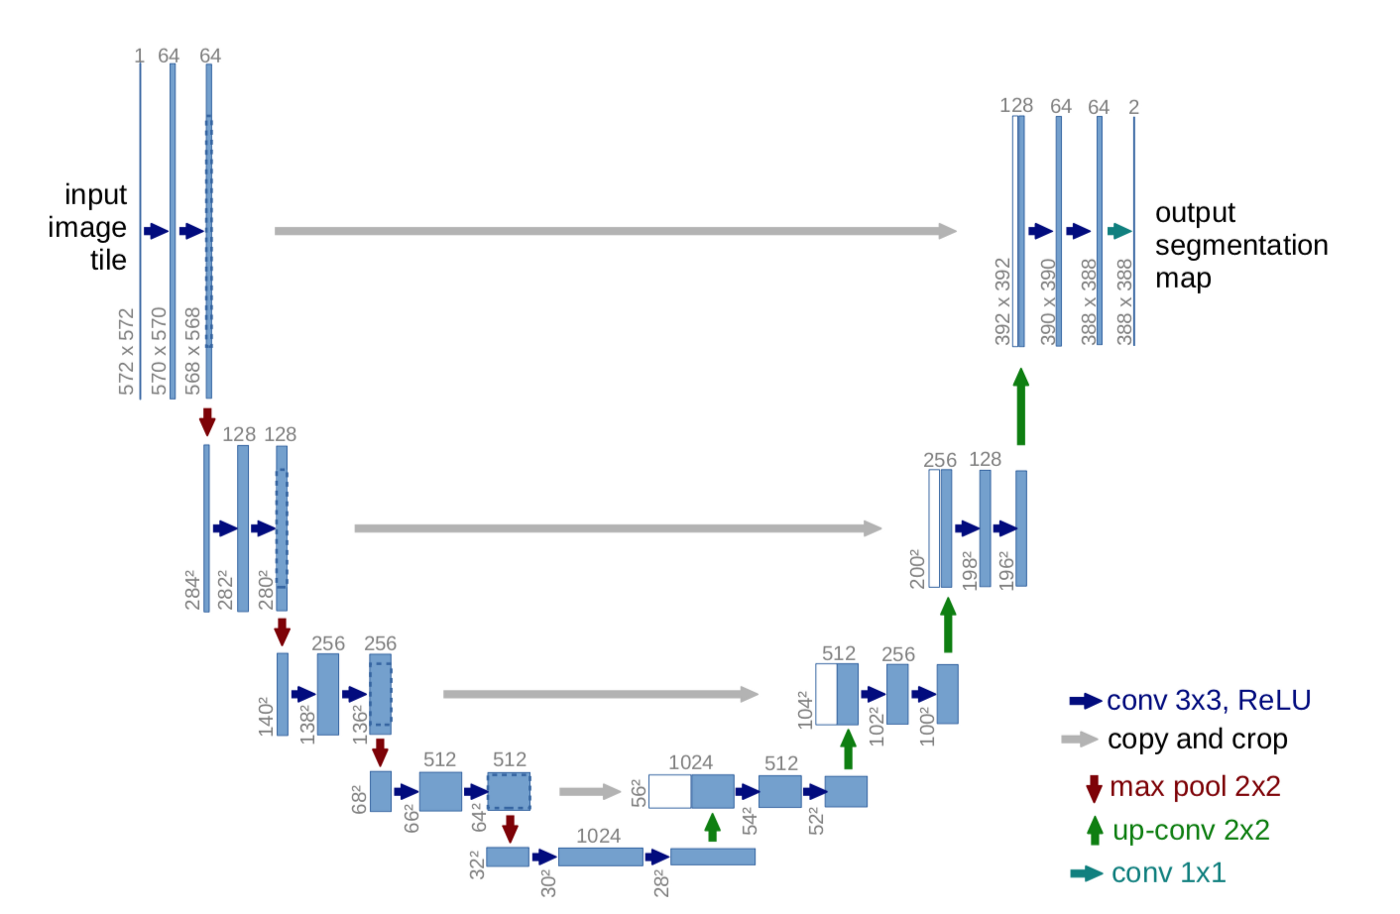

The encoder is composed of blocks involving two Convolution layers with 3x3 filters and two ReLu layers. For our model, we will also add two Batch Normalization Layers after each convolution. This part of the model architecture is represented by the following 'conv_block' class. 

In [28]:
class conv_block(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(conv_block,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out,track_running_stats=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch_out, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out,track_running_stats=False),
            nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.conv(x)
        return x


For the decoder part, we will create two set of blocks with the same functionality. The first one (`up_conv`) is composed of an upsampling layer and a convolution. We also add a Batch Normalization and a ReLu layer. 

In [29]:
class up_conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(up_conv,self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(ch_in,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
		        nn.BatchNorm2d(ch_out,track_running_stats=False),
			      nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.up(x)
        return x

A similar block is created by substituting the upsampling and convolution by a transposed convolution. This block is called `up_Tr_conv`.

In [30]:
class up_Tr_conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(up_Tr_conv,self).__init__()
        self.up = nn.Sequential(
            nn.ConvTranspose2d(ch_in,ch_out,kernel_size=4,stride=2,padding=1,bias=True),
		        nn.BatchNorm2d(ch_out,track_running_stats=False),
			      nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.up(x)
        return x

As a result, two different models are created. The first one is called `U_Net_Up` and involves the Upsampling and Convolution layers. Note that the number of channels is significantly smaller than that of the original UNet model. Also we have introduced the concatenation layers that merge encoder activations with decoder activations (see the `torch.cat((.,.),dim=1)`). 

In [71]:
class U_Net_Up(nn.Module):
    def __init__(self,img_ch=1,output_ch=1):
        super(U_Net_Up,self).__init__()
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)

        self.Conv1 = conv_block(ch_in=img_ch,ch_out=16)
        self.Conv2 = conv_block(ch_in=16,ch_out=32)
        self.Conv3 = conv_block(ch_in=32,ch_out=64)
        self.Conv4 = conv_block(ch_in=64,ch_out=128)
        self.Conv5 = conv_block(ch_in=128,ch_out=256)

        self.Up5 = up_conv(ch_in=256,ch_out=128)
        self.Up_conv5 = conv_block(ch_in=256, ch_out=128)

        self.Up4 = up_conv(ch_in=128,ch_out=64)
        self.Up_conv4 = conv_block(ch_in=128, ch_out=64)
        
        self.Up3 = up_conv(ch_in=64,ch_out=32)
        self.Up_conv3 = conv_block(ch_in=64, ch_out=32)
        
        self.Up2 = up_conv(ch_in=32,ch_out=16)
        self.Up_conv2 = conv_block(ch_in=32, ch_out=16)

        self.Conv_1x1 = nn.Conv2d(16,output_ch,kernel_size=1,stride=1,padding=0)


    def forward(self,x):
        # encoding path
        x1 = self.Conv1(x)

        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.Conv4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.Conv5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        d5 = torch.cat((x4,d5),dim=1)
        
        d5 = self.Up_conv5(d5)
        
        d4 = self.Up4(d5)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_conv2(d2)

        d1 = self.Conv_1x1(d2)

        return d1


The second model: `U_Net_Tr` is the same as the previous one but it includes the Transposed convolution.  

In [72]:
class U_Net_Tr(nn.Module):
    def __init__(self,img_ch=1,output_ch=1):
        super(U_Net_Tr,self).__init__()
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)

        self.Conv1 = conv_block(ch_in=img_ch,ch_out=16)
        self.Conv2 = conv_block(ch_in=16,ch_out=32)
        self.Conv3 = conv_block(ch_in=32,ch_out=64)
        self.Conv4 = conv_block(ch_in=64,ch_out=128)
        self.Conv5 = conv_block(ch_in=128,ch_out=256)

        self.Up5 = up_Tr_conv(ch_in=256,ch_out=128)
        self.Up_conv5 = conv_block(ch_in=256, ch_out=128)

        self.Up4 = up_Tr_conv(ch_in=128,ch_out=64)
        self.Up_conv4 = conv_block(ch_in=128, ch_out=64)
        
        self.Up3 = up_Tr_conv(ch_in=64,ch_out=32)
        self.Up_conv3 = conv_block(ch_in=64, ch_out=32)
        
        self.Up2 = up_Tr_conv(ch_in=32,ch_out=16)
        self.Up_conv2 = conv_block(ch_in=32, ch_out=16)

        self.Conv_1x1 = nn.Conv2d(16,output_ch,kernel_size=1,stride=1,padding=0)


    def forward(self,x):
        # encoding path
        x1 = self.Conv1(x)

        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.Conv4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.Conv5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        d5 = torch.cat((x4,d5),dim=1)
        
        d5 = self.Up_conv5(d5)
        
        d4 = self.Up4(d5)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_conv2(d2)

        d1 = self.Conv_1x1(d2)

        return d1


Let us instantiate first this last model. 

In [73]:
model = U_Net_Tr(output_ch=2)
model.to(device)

summary(model, (1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             160
       BatchNorm2d-2         [-1, 16, 128, 128]              32
              ReLU-3         [-1, 16, 128, 128]               0
            Conv2d-4         [-1, 16, 128, 128]           2,320
       BatchNorm2d-5         [-1, 16, 128, 128]              32
              ReLU-6         [-1, 16, 128, 128]               0
        conv_block-7         [-1, 16, 128, 128]               0
         MaxPool2d-8           [-1, 16, 64, 64]               0
            Conv2d-9           [-1, 32, 64, 64]           4,640
      BatchNorm2d-10           [-1, 32, 64, 64]              64
             ReLU-11           [-1, 32, 64, 64]               0
           Conv2d-12           [-1, 32, 64, 64]           9,248
      BatchNorm2d-13           [-1, 32, 64, 64]              64
             ReLU-14           [-1, 32,

## 4 Training the network
As you are going to run several experiments with different models and/or different hyperparameters, a good way to analyze and compare the results is to use TensorBoard. It is in particular a very good tool to track and visualize metrics such as loss and accuracy 

In [84]:
#!pip install tensorboard
# Run Tensorboard
%load_ext tensorboard
%tensorboard --logdir 'logs'

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 21780), started 1:21:40 ago. (Use '!kill 21780' to kill it.)

Define the loss and the optimization strategy. 

In [76]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-3 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
best_valid_F1 = 0

In order to keep track of the individual experiments that are going to be visualized by TensorBoard, you have to assign a different name for each experiment you run. This is name will be used to create `log` files stored in the `./logs/train/` and `./logs/val/`directories. These `log` files are the input to TensorBoard. 

In [78]:
experiment_name = "U_Net_Tr1"

#from tensorflow import summary
from torch.utils.tensorboard import SummaryWriter

train_log_dir = 'logs/train/' + experiment_name
val_log_dir   = 'logs/val/' + experiment_name
train_summary_writer = SummaryWriter(train_log_dir)
val_summary_writer   = SummaryWriter(val_log_dir)

if not os.path.exists('models'):
    os.makedirs('models')

Let us run the first experiment. 

In [79]:
NEpoch = 40;   # Number of Epoch
MBsize = 32;   # Minibatch size
NI     = 20;   # Batch size for validation
softmax = torch.nn.Softmax(dim=1)
torch.manual_seed(1234)
model.train()

it = 0
# Loop on Epoch
for t in notebook.tqdm(range(NEpoch), desc='Epoch: '):
  model.train()
  idx = torch.randperm(y_train_T.size()[0])
  X_train_T = X_train_T[idx]
  y_train_T = y_train_T[idx]
  
  running_loss = 0
  running_accu = 0
  running_TP, running_P, running_T   = 0.0, 0.0, 0.0

  # Loop on MiniBatch
  for n in notebook.tqdm(range(math.floor(y_train_T.shape[0]/MBsize)), desc='MiniBatch: '):
    X_train_TMB = X_train_T[n*MBsize:(n+1)*MBsize,:,:,:]
    y_train_TMB = y_train_T[n*MBsize:(n+1)*MBsize,:,:]
    X_train_TMB, y_train_TMB = X_train_TMB.to(device), y_train_TMB.to(device)
    
    # Forward pass: compute predicted y by passing x to the model.
    y_pred_TMB = model(X_train_TMB)

    # Compute the loss.
    loss = loss_fn(y_pred_TMB, y_train_TMB)
    running_loss += loss
    
    # Compute accuracy, Precision and recall
    pred    = y_pred_TMB.cpu().detach().numpy()
    pred_th = (pred[:,1,:,:]>0.5).astype(float)
    gt      = y_train_TMB.cpu().numpy()
    running_accu += (pred_th == gt).sum()/gt.size
    running_TP += ((pred_th+gt)==2).sum()
    running_P  += pred_th.sum()
    running_T  += gt.sum()
    
    # Display the training loss and F1
    if n % math.floor(y_train_T.shape[0]/MBsize/5) == 0: 
      precision = running_TP/(running_P+1e-6)
      recall    = running_TP/(running_T+1e-6)
      F1        = 2*precision*recall/(precision+recall+1e-6)
      print("Epoch{0:3d}/MiniBatch{1:4d}, MB.Loss {2:1.3f}, Av.Loss {3:1.3f}, Av.F1 {4:1.3f}"\
            .format(t+1, n+1, loss.item(), running_loss/(n+1), F1))

    # Clear the past gradients and compute new gradient
    optimizer.zero_grad()
    loss.backward()

    # Update of parameters
    optimizer.step()
    
    # Save data to tensorboard                             
    train_summary_writer.add_scalar('loss', loss.item(), global_step=it)
    bTP = ((pred_th+gt)==2).sum()
    bP  = pred_th.sum()
    bT  = gt.sum()
    bprecision = bTP/(bP+1e-6)
    brecall    = bTP/(bT+1e-6)
    bF1        = 2*bprecision*brecall/(bprecision+brecall+1e-6)
    train_summary_writer.add_scalar('F1', bF1, global_step=it)
    it = it + 1
    
  # Evaluate the model on the validation dataset
  model.eval() # This generates poor results if the BatchNorm: "track_running_stats=True"
  running_valid_accu = 0
  valid_running_loss = 0.0
  TP, P, T = 0.0, 0.0, 0.0
  for nv in range(math.floor(y_valid_T.shape[0]/NI)):
    y_pred_T = model(X_valid_T[nv*NI:(nv+1)*NI,:,:,:].to(device))
    #pred     = y_pred_T.cpu().detach().numpy()
    pred     = softmax(y_pred_T).cpu().detach().numpy()  
    pred_th  = (pred[:,1,:,:]>0.5).astype(int)
    gt       = y_valid_T[nv*NI:(nv+1)*NI,:,:].numpy()
    running_valid_accu += np.equal(pred_th, gt).sum()/gt.size
    TP += ((pred_th+gt)==2).sum()
    P  += pred_th.sum()
    T  += gt.sum()

    valid_loss = loss_fn(y_pred_T.cpu(), y_valid_T[nv*NI:(nv+1)*NI,:,:])
    valid_running_loss += valid_loss.item()
  
  # Compute the Validation F1 score and save the model if it is the best one.
  valid_accuracy = running_valid_accu/(nv+1)
  valid_loss     = valid_running_loss/(nv+1)
  precision = TP/(P+1e-6)
  recall    = TP/(T+1e-6)
  F1        = 2*precision*recall/(precision+recall+1e-6)
  if F1 > best_valid_F1:
    best_valid_F1 = F1
    checkpoint = {'model_state_dict': model.state_dict(),'optimizer_state_dict': optimizer.state_dict()}
    torch.save(checkpoint, 'models/checkpoint_' + experiment_name + '.pth')
    
  print("Validation dataset: Loss {0:1.3f}, Accuracy {1:1.3f}, F1 {2:1.3f}, Best F1 {3:1.3f}".format(valid_loss,valid_accuracy,F1,best_valid_F1))
    
  # Learning rate scheduling 
  scheduler.step(valid_loss)
    
  # Save data to tensorboard                        
  val_summary_writer.add_scalar('loss', valid_running_loss/(math.floor(y_valid_T.shape[0]/NI)), global_step=it)
  val_summary_writer.add_scalar('F1', F1, global_step=it)
  
        

Epoch:   0%|          | 0/40 [00:00<?, ?it/s]

MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch  1/MiniBatch   1, MB.Loss 0.637, Av.Loss 0.637, Av.F1 0.018
Epoch  1/MiniBatch  23, MB.Loss 0.430, Av.Loss 0.527, Av.F1 0.297
Epoch  1/MiniBatch  45, MB.Loss 0.443, Av.Loss 0.473, Av.F1 0.401
Epoch  1/MiniBatch  67, MB.Loss 0.356, Av.Loss 0.445, Av.F1 0.435
Epoch  1/MiniBatch  89, MB.Loss 0.346, Av.Loss 0.426, Av.F1 0.472
Epoch  1/MiniBatch 111, MB.Loss 0.438, Av.Loss 0.407, Av.F1 0.514
Validation dataset: Loss 0.333, Accuracy 0.866, F1 0.723, Best F1 0.723


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch  2/MiniBatch   1, MB.Loss 0.309, Av.Loss 0.309, Av.F1 0.774
Epoch  2/MiniBatch  23, MB.Loss 0.330, Av.Loss 0.345, Av.F1 0.649
Epoch  2/MiniBatch  45, MB.Loss 0.216, Av.Loss 0.320, Av.F1 0.660
Epoch  2/MiniBatch  67, MB.Loss 0.309, Av.Loss 0.311, Av.F1 0.678
Epoch  2/MiniBatch  89, MB.Loss 0.289, Av.Loss 0.317, Av.F1 0.684
Epoch  2/MiniBatch 111, MB.Loss 0.438, Av.Loss 0.312, Av.F1 0.693
Validation dataset: Loss 0.271, Accuracy 0.902, F1 0.768, Best F1 0.768


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch  3/MiniBatch   1, MB.Loss 0.250, Av.Loss 0.250, Av.F1 0.683
Epoch  3/MiniBatch  23, MB.Loss 0.414, Av.Loss 0.269, Av.F1 0.761
Epoch  3/MiniBatch  45, MB.Loss 0.338, Av.Loss 0.279, Av.F1 0.737
Epoch  3/MiniBatch  67, MB.Loss 0.361, Av.Loss 0.274, Av.F1 0.748
Epoch  3/MiniBatch  89, MB.Loss 0.226, Av.Loss 0.270, Av.F1 0.747
Epoch  3/MiniBatch 111, MB.Loss 0.256, Av.Loss 0.268, Av.F1 0.749
Validation dataset: Loss 0.241, Accuracy 0.913, F1 0.808, Best F1 0.808


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch  4/MiniBatch   1, MB.Loss 0.346, Av.Loss 0.346, Av.F1 0.698
Epoch  4/MiniBatch  23, MB.Loss 0.281, Av.Loss 0.270, Av.F1 0.737
Epoch  4/MiniBatch  45, MB.Loss 0.201, Av.Loss 0.258, Av.F1 0.761
Epoch  4/MiniBatch  67, MB.Loss 0.201, Av.Loss 0.261, Av.F1 0.758
Epoch  4/MiniBatch  89, MB.Loss 0.226, Av.Loss 0.254, Av.F1 0.763
Epoch  4/MiniBatch 111, MB.Loss 0.189, Av.Loss 0.250, Av.F1 0.769
Validation dataset: Loss 0.233, Accuracy 0.919, F1 0.805, Best F1 0.808


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch  5/MiniBatch   1, MB.Loss 0.231, Av.Loss 0.231, Av.F1 0.780
Epoch  5/MiniBatch  23, MB.Loss 0.253, Av.Loss 0.255, Av.F1 0.743
Epoch  5/MiniBatch  45, MB.Loss 0.187, Av.Loss 0.253, Av.F1 0.767
Epoch  5/MiniBatch  67, MB.Loss 0.191, Av.Loss 0.243, Av.F1 0.782
Epoch  5/MiniBatch  89, MB.Loss 0.205, Av.Loss 0.235, Av.F1 0.790
Epoch  5/MiniBatch 111, MB.Loss 0.262, Av.Loss 0.234, Av.F1 0.791
Validation dataset: Loss 0.212, Accuracy 0.924, F1 0.824, Best F1 0.824


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch  6/MiniBatch   1, MB.Loss 0.165, Av.Loss 0.165, Av.F1 0.861
Epoch  6/MiniBatch  23, MB.Loss 0.260, Av.Loss 0.198, Av.F1 0.815
Epoch  6/MiniBatch  45, MB.Loss 0.204, Av.Loss 0.220, Av.F1 0.796
Epoch  6/MiniBatch  67, MB.Loss 0.248, Av.Loss 0.222, Av.F1 0.797
Epoch  6/MiniBatch  89, MB.Loss 0.251, Av.Loss 0.221, Av.F1 0.806
Epoch  6/MiniBatch 111, MB.Loss 0.151, Av.Loss 0.221, Av.F1 0.804
Validation dataset: Loss 0.210, Accuracy 0.926, F1 0.824, Best F1 0.824


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch  7/MiniBatch   1, MB.Loss 0.188, Av.Loss 0.188, Av.F1 0.802
Epoch  7/MiniBatch  23, MB.Loss 0.268, Av.Loss 0.240, Av.F1 0.770
Epoch  7/MiniBatch  45, MB.Loss 0.212, Av.Loss 0.228, Av.F1 0.782
Epoch  7/MiniBatch  67, MB.Loss 0.257, Av.Loss 0.232, Av.F1 0.785
Epoch  7/MiniBatch  89, MB.Loss 0.236, Av.Loss 0.228, Av.F1 0.792
Epoch  7/MiniBatch 111, MB.Loss 0.172, Av.Loss 0.223, Av.F1 0.793
Validation dataset: Loss 0.203, Accuracy 0.923, F1 0.816, Best F1 0.824


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch  8/MiniBatch   1, MB.Loss 0.188, Av.Loss 0.188, Av.F1 0.759
Epoch  8/MiniBatch  23, MB.Loss 0.148, Av.Loss 0.217, Av.F1 0.806
Epoch  8/MiniBatch  45, MB.Loss 0.249, Av.Loss 0.217, Av.F1 0.810
Epoch  8/MiniBatch  67, MB.Loss 0.280, Av.Loss 0.212, Av.F1 0.813
Epoch  8/MiniBatch  89, MB.Loss 0.153, Av.Loss 0.215, Av.F1 0.813
Epoch  8/MiniBatch 111, MB.Loss 0.177, Av.Loss 0.213, Av.F1 0.816
Validation dataset: Loss 0.192, Accuracy 0.931, F1 0.840, Best F1 0.840


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch  9/MiniBatch   1, MB.Loss 0.156, Av.Loss 0.156, Av.F1 0.861
Epoch  9/MiniBatch  23, MB.Loss 0.186, Av.Loss 0.173, Av.F1 0.838
Epoch  9/MiniBatch  45, MB.Loss 0.172, Av.Loss 0.185, Av.F1 0.834
Epoch  9/MiniBatch  67, MB.Loss 0.297, Av.Loss 0.194, Av.F1 0.829
Epoch  9/MiniBatch  89, MB.Loss 0.172, Av.Loss 0.198, Av.F1 0.827
Epoch  9/MiniBatch 111, MB.Loss 0.153, Av.Loss 0.201, Av.F1 0.824
Validation dataset: Loss 0.194, Accuracy 0.931, F1 0.843, Best F1 0.843


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 10/MiniBatch   1, MB.Loss 0.164, Av.Loss 0.164, Av.F1 0.799
Epoch 10/MiniBatch  23, MB.Loss 0.136, Av.Loss 0.178, Av.F1 0.840
Epoch 10/MiniBatch  45, MB.Loss 0.242, Av.Loss 0.183, Av.F1 0.848
Epoch 10/MiniBatch  67, MB.Loss 0.154, Av.Loss 0.183, Av.F1 0.845
Epoch 10/MiniBatch  89, MB.Loss 0.192, Av.Loss 0.183, Av.F1 0.844
Epoch 10/MiniBatch 111, MB.Loss 0.092, Av.Loss 0.186, Av.F1 0.838
Validation dataset: Loss 0.178, Accuracy 0.936, F1 0.857, Best F1 0.857


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 11/MiniBatch   1, MB.Loss 0.089, Av.Loss 0.089, Av.F1 0.948
Epoch 11/MiniBatch  23, MB.Loss 0.138, Av.Loss 0.190, Av.F1 0.847
Epoch 11/MiniBatch  45, MB.Loss 0.147, Av.Loss 0.183, Av.F1 0.848
Epoch 11/MiniBatch  67, MB.Loss 0.196, Av.Loss 0.192, Av.F1 0.835
Epoch 11/MiniBatch  89, MB.Loss 0.192, Av.Loss 0.190, Av.F1 0.837
Epoch 11/MiniBatch 111, MB.Loss 0.197, Av.Loss 0.183, Av.F1 0.842
Validation dataset: Loss 0.173, Accuracy 0.939, F1 0.862, Best F1 0.862


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 12/MiniBatch   1, MB.Loss 0.098, Av.Loss 0.098, Av.F1 0.925
Epoch 12/MiniBatch  23, MB.Loss 0.172, Av.Loss 0.147, Av.F1 0.886
Epoch 12/MiniBatch  45, MB.Loss 0.114, Av.Loss 0.173, Av.F1 0.862
Epoch 12/MiniBatch  67, MB.Loss 0.131, Av.Loss 0.173, Av.F1 0.860
Epoch 12/MiniBatch  89, MB.Loss 0.165, Av.Loss 0.178, Av.F1 0.855
Epoch 12/MiniBatch 111, MB.Loss 0.132, Av.Loss 0.174, Av.F1 0.855
Validation dataset: Loss 0.169, Accuracy 0.934, F1 0.853, Best F1 0.862


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 13/MiniBatch   1, MB.Loss 0.159, Av.Loss 0.159, Av.F1 0.864
Epoch 13/MiniBatch  23, MB.Loss 0.112, Av.Loss 0.168, Av.F1 0.859
Epoch 13/MiniBatch  45, MB.Loss 0.187, Av.Loss 0.175, Av.F1 0.845
Epoch 13/MiniBatch  67, MB.Loss 0.294, Av.Loss 0.179, Av.F1 0.843
Epoch 13/MiniBatch  89, MB.Loss 0.139, Av.Loss 0.176, Av.F1 0.846
Epoch 13/MiniBatch 111, MB.Loss 0.122, Av.Loss 0.170, Av.F1 0.853
Validation dataset: Loss 0.196, Accuracy 0.924, F1 0.837, Best F1 0.862


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 14/MiniBatch   1, MB.Loss 0.151, Av.Loss 0.151, Av.F1 0.878
Epoch 14/MiniBatch  23, MB.Loss 0.124, Av.Loss 0.159, Av.F1 0.873
Epoch 14/MiniBatch  45, MB.Loss 0.184, Av.Loss 0.164, Av.F1 0.864
Epoch 14/MiniBatch  67, MB.Loss 0.160, Av.Loss 0.159, Av.F1 0.864
Epoch 14/MiniBatch  89, MB.Loss 0.136, Av.Loss 0.164, Av.F1 0.860
Epoch 14/MiniBatch 111, MB.Loss 0.202, Av.Loss 0.168, Av.F1 0.854
Validation dataset: Loss 0.177, Accuracy 0.934, F1 0.854, Best F1 0.862


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 15/MiniBatch   1, MB.Loss 0.121, Av.Loss 0.121, Av.F1 0.943
Epoch 15/MiniBatch  23, MB.Loss 0.220, Av.Loss 0.168, Av.F1 0.867
Epoch 15/MiniBatch  45, MB.Loss 0.277, Av.Loss 0.161, Av.F1 0.864
Epoch 15/MiniBatch  67, MB.Loss 0.243, Av.Loss 0.156, Av.F1 0.864
Epoch 15/MiniBatch  89, MB.Loss 0.139, Av.Loss 0.164, Av.F1 0.855
Epoch 15/MiniBatch 111, MB.Loss 0.150, Av.Loss 0.164, Av.F1 0.856
Validation dataset: Loss 0.206, Accuracy 0.916, F1 0.833, Best F1 0.862


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 16/MiniBatch   1, MB.Loss 0.134, Av.Loss 0.134, Av.F1 0.909
Epoch 16/MiniBatch  23, MB.Loss 0.128, Av.Loss 0.155, Av.F1 0.875
Epoch 16/MiniBatch  45, MB.Loss 0.146, Av.Loss 0.155, Av.F1 0.872
Epoch 16/MiniBatch  67, MB.Loss 0.158, Av.Loss 0.154, Av.F1 0.872
Epoch 16/MiniBatch  89, MB.Loss 0.096, Av.Loss 0.156, Av.F1 0.869
Epoch 16/MiniBatch 111, MB.Loss 0.221, Av.Loss 0.156, Av.F1 0.868
Validation dataset: Loss 0.173, Accuracy 0.942, F1 0.871, Best F1 0.871


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 17/MiniBatch   1, MB.Loss 0.159, Av.Loss 0.159, Av.F1 0.867
Epoch 17/MiniBatch  23, MB.Loss 0.101, Av.Loss 0.147, Av.F1 0.888
Epoch 17/MiniBatch  45, MB.Loss 0.191, Av.Loss 0.154, Av.F1 0.878
Epoch 17/MiniBatch  67, MB.Loss 0.154, Av.Loss 0.153, Av.F1 0.873
Epoch 17/MiniBatch  89, MB.Loss 0.127, Av.Loss 0.152, Av.F1 0.875
Epoch 17/MiniBatch 111, MB.Loss 0.319, Av.Loss 0.156, Av.F1 0.870
Validation dataset: Loss 0.182, Accuracy 0.937, F1 0.855, Best F1 0.871


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 18/MiniBatch   1, MB.Loss 0.090, Av.Loss 0.090, Av.F1 0.934
Epoch 18/MiniBatch  23, MB.Loss 0.249, Av.Loss 0.162, Av.F1 0.838
Epoch 18/MiniBatch  45, MB.Loss 0.159, Av.Loss 0.154, Av.F1 0.853
Epoch 18/MiniBatch  67, MB.Loss 0.111, Av.Loss 0.147, Av.F1 0.862
Epoch 18/MiniBatch  89, MB.Loss 0.104, Av.Loss 0.151, Av.F1 0.865
Epoch 18/MiniBatch 111, MB.Loss 0.103, Av.Loss 0.151, Av.F1 0.866
Validation dataset: Loss 0.154, Accuracy 0.943, F1 0.873, Best F1 0.873


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 19/MiniBatch   1, MB.Loss 0.084, Av.Loss 0.084, Av.F1 0.909
Epoch 19/MiniBatch  23, MB.Loss 0.132, Av.Loss 0.114, Av.F1 0.912
Epoch 19/MiniBatch  45, MB.Loss 0.113, Av.Loss 0.127, Av.F1 0.898
Epoch 19/MiniBatch  67, MB.Loss 0.134, Av.Loss 0.133, Av.F1 0.888
Epoch 19/MiniBatch  89, MB.Loss 0.333, Av.Loss 0.139, Av.F1 0.884
Epoch 19/MiniBatch 111, MB.Loss 0.140, Av.Loss 0.145, Av.F1 0.878
Validation dataset: Loss 0.161, Accuracy 0.943, F1 0.871, Best F1 0.873


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 20/MiniBatch   1, MB.Loss 0.101, Av.Loss 0.101, Av.F1 0.902
Epoch 20/MiniBatch  23, MB.Loss 0.124, Av.Loss 0.146, Av.F1 0.876
Epoch 20/MiniBatch  45, MB.Loss 0.068, Av.Loss 0.134, Av.F1 0.890
Epoch 20/MiniBatch  67, MB.Loss 0.229, Av.Loss 0.140, Av.F1 0.886
Epoch 20/MiniBatch  89, MB.Loss 0.133, Av.Loss 0.137, Av.F1 0.884
Epoch 20/MiniBatch 111, MB.Loss 0.207, Av.Loss 0.136, Av.F1 0.886
Validation dataset: Loss 0.167, Accuracy 0.941, F1 0.866, Best F1 0.873


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 21/MiniBatch   1, MB.Loss 0.082, Av.Loss 0.082, Av.F1 0.923
Epoch 21/MiniBatch  23, MB.Loss 0.084, Av.Loss 0.123, Av.F1 0.884
Epoch 21/MiniBatch  45, MB.Loss 0.157, Av.Loss 0.119, Av.F1 0.901
Epoch 21/MiniBatch  67, MB.Loss 0.189, Av.Loss 0.120, Av.F1 0.901
Epoch 21/MiniBatch  89, MB.Loss 0.174, Av.Loss 0.123, Av.F1 0.896
Epoch 21/MiniBatch 111, MB.Loss 0.182, Av.Loss 0.127, Av.F1 0.890
Validation dataset: Loss 0.172, Accuracy 0.939, F1 0.869, Best F1 0.873


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 22/MiniBatch   1, MB.Loss 0.208, Av.Loss 0.208, Av.F1 0.845
Epoch 22/MiniBatch  23, MB.Loss 0.102, Av.Loss 0.134, Av.F1 0.885
Epoch 22/MiniBatch  45, MB.Loss 0.079, Av.Loss 0.130, Av.F1 0.899
Epoch 22/MiniBatch  67, MB.Loss 0.118, Av.Loss 0.138, Av.F1 0.889
Epoch 22/MiniBatch  89, MB.Loss 0.156, Av.Loss 0.141, Av.F1 0.885
Epoch 22/MiniBatch 111, MB.Loss 0.165, Av.Loss 0.141, Av.F1 0.883
Validation dataset: Loss 0.158, Accuracy 0.943, F1 0.873, Best F1 0.873


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 23/MiniBatch   1, MB.Loss 0.060, Av.Loss 0.060, Av.F1 0.949
Epoch 23/MiniBatch  23, MB.Loss 0.159, Av.Loss 0.115, Av.F1 0.889
Epoch 23/MiniBatch  45, MB.Loss 0.082, Av.Loss 0.124, Av.F1 0.890
Epoch 23/MiniBatch  67, MB.Loss 0.146, Av.Loss 0.127, Av.F1 0.889
Epoch 23/MiniBatch  89, MB.Loss 0.105, Av.Loss 0.126, Av.F1 0.891
Epoch 23/MiniBatch 111, MB.Loss 0.099, Av.Loss 0.123, Av.F1 0.895
Validation dataset: Loss 0.157, Accuracy 0.943, F1 0.873, Best F1 0.873


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 24/MiniBatch   1, MB.Loss 0.054, Av.Loss 0.054, Av.F1 0.960
Epoch 24/MiniBatch  23, MB.Loss 0.107, Av.Loss 0.098, Av.F1 0.920
Epoch 24/MiniBatch  45, MB.Loss 0.095, Av.Loss 0.111, Av.F1 0.910
Epoch 24/MiniBatch  67, MB.Loss 0.168, Av.Loss 0.123, Av.F1 0.899
Epoch 24/MiniBatch  89, MB.Loss 0.140, Av.Loss 0.130, Av.F1 0.890
Epoch 24/MiniBatch 111, MB.Loss 0.103, Av.Loss 0.127, Av.F1 0.894
Validation dataset: Loss 0.155, Accuracy 0.944, F1 0.873, Best F1 0.873


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 25/MiniBatch   1, MB.Loss 0.057, Av.Loss 0.057, Av.F1 0.961
Epoch 25/MiniBatch  23, MB.Loss 0.111, Av.Loss 0.118, Av.F1 0.898
Epoch 25/MiniBatch  45, MB.Loss 0.144, Av.Loss 0.121, Av.F1 0.896
Epoch 25/MiniBatch  67, MB.Loss 0.064, Av.Loss 0.124, Av.F1 0.895
Epoch 25/MiniBatch  89, MB.Loss 0.100, Av.Loss 0.122, Av.F1 0.897
Epoch 25/MiniBatch 111, MB.Loss 0.070, Av.Loss 0.122, Av.F1 0.897
Validation dataset: Loss 0.162, Accuracy 0.943, F1 0.870, Best F1 0.873


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 26/MiniBatch   1, MB.Loss 0.118, Av.Loss 0.118, Av.F1 0.868
Epoch 26/MiniBatch  23, MB.Loss 0.097, Av.Loss 0.109, Av.F1 0.906
Epoch 26/MiniBatch  45, MB.Loss 0.150, Av.Loss 0.108, Av.F1 0.913
Epoch 26/MiniBatch  67, MB.Loss 0.069, Av.Loss 0.106, Av.F1 0.914
Epoch 26/MiniBatch  89, MB.Loss 0.085, Av.Loss 0.108, Av.F1 0.910
Epoch 26/MiniBatch 111, MB.Loss 0.099, Av.Loss 0.110, Av.F1 0.909
Validation dataset: Loss 0.164, Accuracy 0.940, F1 0.871, Best F1 0.873


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 27/MiniBatch   1, MB.Loss 0.070, Av.Loss 0.070, Av.F1 0.957
Epoch 27/MiniBatch  23, MB.Loss 0.082, Av.Loss 0.106, Av.F1 0.911
Epoch 27/MiniBatch  45, MB.Loss 0.068, Av.Loss 0.101, Av.F1 0.914
Epoch 27/MiniBatch  67, MB.Loss 0.121, Av.Loss 0.101, Av.F1 0.917
Epoch 27/MiniBatch  89, MB.Loss 0.054, Av.Loss 0.099, Av.F1 0.920
Epoch 27/MiniBatch 111, MB.Loss 0.110, Av.Loss 0.103, Av.F1 0.916
Validation dataset: Loss 0.172, Accuracy 0.943, F1 0.871, Best F1 0.873


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 28/MiniBatch   1, MB.Loss 0.167, Av.Loss 0.167, Av.F1 0.833
Epoch 28/MiniBatch  23, MB.Loss 0.126, Av.Loss 0.102, Av.F1 0.901
Epoch 28/MiniBatch  45, MB.Loss 0.064, Av.Loss 0.092, Av.F1 0.918
Epoch 28/MiniBatch  67, MB.Loss 0.074, Av.Loss 0.093, Av.F1 0.920
Epoch 28/MiniBatch  89, MB.Loss 0.082, Av.Loss 0.097, Av.F1 0.918
Epoch 28/MiniBatch 111, MB.Loss 0.090, Av.Loss 0.097, Av.F1 0.916
Validation dataset: Loss 0.186, Accuracy 0.945, F1 0.878, Best F1 0.878


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 29/MiniBatch   1, MB.Loss 0.098, Av.Loss 0.098, Av.F1 0.899
Epoch 29/MiniBatch  23, MB.Loss 0.040, Av.Loss 0.082, Av.F1 0.933
Epoch 29/MiniBatch  45, MB.Loss 0.107, Av.Loss 0.093, Av.F1 0.928
Epoch 29/MiniBatch  67, MB.Loss 0.104, Av.Loss 0.089, Av.F1 0.931
Epoch 29/MiniBatch  89, MB.Loss 0.216, Av.Loss 0.091, Av.F1 0.928
Epoch 29/MiniBatch 111, MB.Loss 0.320, Av.Loss 0.096, Av.F1 0.924
Validation dataset: Loss 0.241, Accuracy 0.914, F1 0.789, Best F1 0.878


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 30/MiniBatch   1, MB.Loss 0.309, Av.Loss 0.309, Av.F1 0.725
Epoch 30/MiniBatch  23, MB.Loss 0.078, Av.Loss 0.119, Av.F1 0.867
Epoch 30/MiniBatch  45, MB.Loss 0.136, Av.Loss 0.104, Av.F1 0.896
Epoch 30/MiniBatch  67, MB.Loss 0.054, Av.Loss 0.096, Av.F1 0.909
Epoch 30/MiniBatch  89, MB.Loss 0.071, Av.Loss 0.091, Av.F1 0.919
Epoch 30/MiniBatch 111, MB.Loss 0.091, Av.Loss 0.088, Av.F1 0.923
Validation dataset: Loss 0.157, Accuracy 0.945, F1 0.880, Best F1 0.880


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 31/MiniBatch   1, MB.Loss 0.059, Av.Loss 0.059, Av.F1 0.969
Epoch 31/MiniBatch  23, MB.Loss 0.065, Av.Loss 0.071, Av.F1 0.946
Epoch 31/MiniBatch  45, MB.Loss 0.063, Av.Loss 0.070, Av.F1 0.943
Epoch 31/MiniBatch  67, MB.Loss 0.056, Av.Loss 0.069, Av.F1 0.943
Epoch 31/MiniBatch  89, MB.Loss 0.082, Av.Loss 0.069, Av.F1 0.944
Epoch 31/MiniBatch 111, MB.Loss 0.046, Av.Loss 0.067, Av.F1 0.947
Validation dataset: Loss 0.170, Accuracy 0.945, F1 0.880, Best F1 0.880


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 32/MiniBatch   1, MB.Loss 0.060, Av.Loss 0.060, Av.F1 0.938
Epoch 32/MiniBatch  23, MB.Loss 0.132, Av.Loss 0.061, Av.F1 0.956
Epoch 32/MiniBatch  45, MB.Loss 0.035, Av.Loss 0.061, Av.F1 0.955
Epoch 32/MiniBatch  67, MB.Loss 0.052, Av.Loss 0.062, Av.F1 0.951
Epoch 32/MiniBatch  89, MB.Loss 0.060, Av.Loss 0.063, Av.F1 0.951
Epoch 32/MiniBatch 111, MB.Loss 0.072, Av.Loss 0.064, Av.F1 0.950
Validation dataset: Loss 0.171, Accuracy 0.947, F1 0.883, Best F1 0.883


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 33/MiniBatch   1, MB.Loss 0.077, Av.Loss 0.077, Av.F1 0.940
Epoch 33/MiniBatch  23, MB.Loss 0.040, Av.Loss 0.066, Av.F1 0.949
Epoch 33/MiniBatch  45, MB.Loss 0.078, Av.Loss 0.061, Av.F1 0.954
Epoch 33/MiniBatch  67, MB.Loss 0.043, Av.Loss 0.061, Av.F1 0.954
Epoch 33/MiniBatch  89, MB.Loss 0.087, Av.Loss 0.061, Av.F1 0.954
Epoch 33/MiniBatch 111, MB.Loss 0.048, Av.Loss 0.062, Av.F1 0.953
Validation dataset: Loss 0.172, Accuracy 0.947, F1 0.884, Best F1 0.884


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 34/MiniBatch   1, MB.Loss 0.045, Av.Loss 0.045, Av.F1 0.972
Epoch 34/MiniBatch  23, MB.Loss 0.054, Av.Loss 0.057, Av.F1 0.957
Epoch 34/MiniBatch  45, MB.Loss 0.063, Av.Loss 0.061, Av.F1 0.954
Epoch 34/MiniBatch  67, MB.Loss 0.048, Av.Loss 0.060, Av.F1 0.954
Epoch 34/MiniBatch  89, MB.Loss 0.054, Av.Loss 0.058, Av.F1 0.956
Epoch 34/MiniBatch 111, MB.Loss 0.072, Av.Loss 0.060, Av.F1 0.954
Validation dataset: Loss 0.175, Accuracy 0.947, F1 0.884, Best F1 0.884


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 35/MiniBatch   1, MB.Loss 0.053, Av.Loss 0.053, Av.F1 0.959
Epoch 35/MiniBatch  23, MB.Loss 0.078, Av.Loss 0.064, Av.F1 0.953
Epoch 35/MiniBatch  45, MB.Loss 0.050, Av.Loss 0.061, Av.F1 0.955
Epoch 35/MiniBatch  67, MB.Loss 0.040, Av.Loss 0.058, Av.F1 0.957
Epoch 35/MiniBatch  89, MB.Loss 0.038, Av.Loss 0.057, Av.F1 0.957
Epoch 35/MiniBatch 111, MB.Loss 0.093, Av.Loss 0.057, Av.F1 0.957
Validation dataset: Loss 0.181, Accuracy 0.947, F1 0.884, Best F1 0.884


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 36/MiniBatch   1, MB.Loss 0.039, Av.Loss 0.039, Av.F1 0.953
Epoch 36/MiniBatch  23, MB.Loss 0.062, Av.Loss 0.064, Av.F1 0.951
Epoch 36/MiniBatch  45, MB.Loss 0.036, Av.Loss 0.061, Av.F1 0.953
Epoch 36/MiniBatch  67, MB.Loss 0.044, Av.Loss 0.059, Av.F1 0.955
Epoch 36/MiniBatch  89, MB.Loss 0.052, Av.Loss 0.058, Av.F1 0.956
Epoch 36/MiniBatch 111, MB.Loss 0.030, Av.Loss 0.057, Av.F1 0.957
Validation dataset: Loss 0.182, Accuracy 0.947, F1 0.884, Best F1 0.884


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 37/MiniBatch   1, MB.Loss 0.046, Av.Loss 0.046, Av.F1 0.968
Epoch 37/MiniBatch  23, MB.Loss 0.069, Av.Loss 0.055, Av.F1 0.959
Epoch 37/MiniBatch  45, MB.Loss 0.030, Av.Loss 0.054, Av.F1 0.958
Epoch 37/MiniBatch  67, MB.Loss 0.042, Av.Loss 0.054, Av.F1 0.957
Epoch 37/MiniBatch  89, MB.Loss 0.040, Av.Loss 0.053, Av.F1 0.958
Epoch 37/MiniBatch 111, MB.Loss 0.048, Av.Loss 0.055, Av.F1 0.958
Validation dataset: Loss 0.185, Accuracy 0.946, F1 0.882, Best F1 0.884


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 38/MiniBatch   1, MB.Loss 0.034, Av.Loss 0.034, Av.F1 0.982
Epoch 38/MiniBatch  23, MB.Loss 0.066, Av.Loss 0.051, Av.F1 0.965
Epoch 38/MiniBatch  45, MB.Loss 0.061, Av.Loss 0.050, Av.F1 0.964
Epoch 38/MiniBatch  67, MB.Loss 0.059, Av.Loss 0.052, Av.F1 0.961
Epoch 38/MiniBatch  89, MB.Loss 0.030, Av.Loss 0.052, Av.F1 0.960
Epoch 38/MiniBatch 111, MB.Loss 0.047, Av.Loss 0.053, Av.F1 0.960
Validation dataset: Loss 0.184, Accuracy 0.947, F1 0.884, Best F1 0.884


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 39/MiniBatch   1, MB.Loss 0.032, Av.Loss 0.032, Av.F1 0.977
Epoch 39/MiniBatch  23, MB.Loss 0.033, Av.Loss 0.045, Av.F1 0.966
Epoch 39/MiniBatch  45, MB.Loss 0.034, Av.Loss 0.049, Av.F1 0.961
Epoch 39/MiniBatch  67, MB.Loss 0.042, Av.Loss 0.052, Av.F1 0.960
Epoch 39/MiniBatch  89, MB.Loss 0.035, Av.Loss 0.052, Av.F1 0.960
Epoch 39/MiniBatch 111, MB.Loss 0.061, Av.Loss 0.051, Av.F1 0.961
Validation dataset: Loss 0.184, Accuracy 0.947, F1 0.884, Best F1 0.884


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 40/MiniBatch   1, MB.Loss 0.042, Av.Loss 0.042, Av.F1 0.963
Epoch 40/MiniBatch  23, MB.Loss 0.046, Av.Loss 0.056, Av.F1 0.957
Epoch 40/MiniBatch  45, MB.Loss 0.048, Av.Loss 0.053, Av.F1 0.958
Epoch 40/MiniBatch  67, MB.Loss 0.046, Av.Loss 0.053, Av.F1 0.958
Epoch 40/MiniBatch  89, MB.Loss 0.096, Av.Loss 0.052, Av.F1 0.959
Epoch 40/MiniBatch 111, MB.Loss 0.035, Av.Loss 0.052, Av.F1 0.960
Validation dataset: Loss 0.181, Accuracy 0.947, F1 0.886, Best F1 0.886


## 5 Test on Validation data
The trained network can now be used on the validation data to assess its performance and visualize the results. Let us specify the model to be used.

In [80]:
model = U_Net_Tr(output_ch=2)
model.to(device)

print(model)
summary(model, (1, 128, 128))

U_Net_Tr(
  (Maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv1): conv_block(
    (conv): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (5): ReLU(inplace=True)
    )
  )
  (Conv2): conv_block(
    (conv): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (5): ReLU(inplace=True)
   

Retrieve and load the best stored checkpoint for the model.

In [81]:
experiment_name = "U_Net_Tr1"
checkpoint = torch.load('models/checkpoint_' + experiment_name + '.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

U_Net_Tr(
  (Maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv1): conv_block(
    (conv): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (5): ReLU(inplace=True)
    )
  )
  (Conv2): conv_block(
    (conv): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (5): ReLU(inplace=True)
   

Assess the performances of the model on the validation dataset. 

In [82]:
# Calculate all prediction on the validation dataset
NI = 20
TP, P, T = 0.0, 0.0, 0.0
all_pred = np.zeros_like(y_valid_T, dtype=float)
running_valid_accu = 0
for nv in range(math.floor(y_valid_T.shape[0]/NI)):
  y_pred_T = model(X_valid_T[nv*NI:(nv+1)*NI,:,:,:].to(device))
  pred     = softmax(y_pred_T).cpu().detach().numpy()
  pred_th  = (pred[:,1,:,:]>0.5).astype(int)
  gt       = y_valid_T[nv*NI:(nv+1)*NI,:,:].numpy()
  running_valid_accu += np.equal(pred_th, gt).sum()/gt.size
  TP += ((pred_th+gt)==2).sum()
  P  += pred_th.sum()
  T  += gt.sum()
  all_pred[nv*NI:(nv+1)*NI,:,:]=pred[:,1,:,:]

pred_th = (all_pred[:,:,:]>0.5).astype(int)
valid_accuracy = running_valid_accu/(nv+1)
print("Validation Accuracy {0:1.3f}".format(valid_accuracy))
precision = TP/(P+1e-6)
recall    = TP/(T+1e-6)
F1        = 2*precision*recall/(precision+recall+1e-6)
print("Precision: {0:1.3f}, Recall: {1:1.3f}, F1 score: {2:1.3f}".format(precision,recall,F1))

Validation Accuracy 0.947
Precision: 0.909, Recall: 0.863, F1 score: 0.886


Visualize random images from the validation dataset. 

Image 363
Accuracy on this image 0.990
Precision: 0.986, Recall: 0.999, F1 score: 0.992


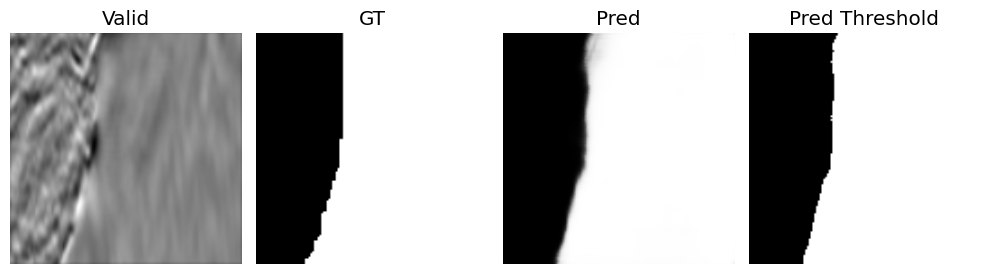

In [83]:
# Sample the validation dataset
ima = random.randint(0, y_valid.shape[0]-1)
print("Image {0}".format(ima))
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (10, 15))
ax1.imshow(valid[ima,0,:,:], cmap = 'gray', interpolation = 'bilinear')
ax1.set_title('Valid'), ax1.axis('off')
ax2.imshow(gt_valid[ima,:,:], cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('GT'), ax2.axis('off')
ax3.imshow(all_pred[ima,:,:], cmap = 'gray', interpolation = 'bilinear')
ax3.set_title('Pred'), ax3.axis('off')
ax4.imshow(pred_th[ima,:,:], cmap = 'gray', interpolation = 'bilinear')
ax4.set_title('Pred Threshold'), ax4.axis('off')
fig.tight_layout()

accuracy = (pred_th[ima,:,:] == gt_valid[ima,:,:]).sum()/gt_valid.shape[1]/gt_valid.shape[2]
print("Accuracy on this image {0:1.3f}".format(accuracy))

TP = ((pred_th[ima,:,:]+gt_valid[ima,:,:])==2).sum()
P  = (pred_th[ima,:,:]).sum()
T  = (gt_valid[ima,:,:]).sum()
precision = TP/(P+1e-6)
recall    = TP/(T+1e-6)
F1        = 2*precision*recall/(precision+recall+1e-6)
if T>0:
  print("Precision: {0:1.3f}, Recall: {1:1.3f}, F1 score: {2:1.3f}".format(precision,recall,F1))

## 6 U_Net_Tr and U_Net_Up Comparison 
<font color='purple'> Once you have performed this first training and evaluation of the `U_Net_Tr` model, go back to the beginning of section 4 and run a similar experiment with the `U_Net_Up` model. Report here your conclusions about the comparison of the two models. 
 </font>


**Comparant els dos models, i veient la quantitat de paràmetres, podem veure com en U_Net_Tr té prop de 300.000 paràmetres més que el U_Net_Up. Llavors, hem de tenir en compte el balanç entre l'eficiència del nostre model i la precisió i exactitud que pugui tenir fent les diferents prediccions.**

**Si veiem les mètriques del conjunt de validació del U_Net_Up, tenim els següents resultats:**

**Validation Accuracy : 0.947**

**Precision: 0.911, Recall: 0.861, F1 score: 0.885**

**I si mirem el mateix per al model U_Net_Tr, que com ben bé sabem, tenim prop de 300.000 paràmetres més, les mètriques són les següents:**

**Validation Accuracy : 0.947**

**Precision: 0.909, Recall: 0.863, F1 score: 0.886**

**Per tant, podem veure com el fet de tenir un nombre de paràmetres considerablement molt més gran, no fa variar gairebé res com es comporta el nostre model, per tant, podríem veure com a més adequat aquell que amb molts menys paràmetres, és a dir, aquell que usa Upsamplings i no Convolucions Transposades, té un comportament similar al que té el nombre de paràmetres més elevat. Llavors, considerem U_Net_Up com el millor model.**

**Ara bé, a què es deu això? Nosaltres, podríem donar dues explicacions. La primera, és que com hem vist amb les imatges que entrenem, un model simple ja és suficient, en aquest cas el que usa Upsampling, per poder obtenir una predicció acurada ja que són imatges molt simples i valors de píxels propers són molt similars. És a dir, no caldria la Convolució Transposada per obtenir uns bons resultats. I la segona conclusió a la qual hem pogut arribar es basa en el fet que sabem que s'arriba a un punt que el fet d'augmentar el nombre de paràmetres no millora el comportament d'un model, i pot ser això és el que ha passat.**

## 7 The challenge

<font color='purple'> So, now it is time to challenge you to create a model that may outperform the models studied so far. Report here your main conclusions and specify the model (feel free to use "Code cells" if necessary for your answer). 
 </font>
 

In [46]:
class res_conv_block(nn.Module):
    def __init__(self, ch_in, ch_out):
        super(res_conv_block,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out,track_running_stats=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch_out, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out,track_running_stats=False)
        )
        self.ReLU = nn.ReLU(inplace=True)

        self.skip = nn.Sequential(
        nn.Conv2d(ch_in, ch_out, kernel_size=1, stride=1, padding=0, bias=True)
        )

    def forward(self,x):
        x = self.ReLU(self.conv(x) + self.skip(x))
        return x

In [47]:
class up_Tr_conv(nn.Module):
    def __init__(self, ch_in, ch_out):
        super(up_Tr_conv, self).__init__()
        self.up = nn.Sequential(
            nn.ConvTranspose2d(ch_in, ch_out, kernel_size=4, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(ch_out, track_running_stats=False),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x

In [48]:
class Res_U_Net_Tr(nn.Module):
    def __init__(self, img_ch=1, output_ch=1):
        super(Res_U_Net_Tr, self).__init__()
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)

        self.Conv1 = res_conv_block(ch_in=img_ch,ch_out=16)
        self.Conv2 = res_conv_block(ch_in=16,ch_out=32)
        self.Conv3 = res_conv_block(ch_in=32,ch_out=64)
        self.Conv4 = res_conv_block(ch_in=64,ch_out=128)
        self.Conv5 = res_conv_block(ch_in=128,ch_out=256)

        self.Up5 = up_Tr_conv(ch_in=256,ch_out=128)
        self.Up_conv5 = conv_block(ch_in=256, ch_out=128)

        self.Up4 = up_Tr_conv(ch_in=128,ch_out=64)
        self.Up_conv4 = conv_block(ch_in=128, ch_out=64)
        
        self.Up3 = up_Tr_conv(ch_in=64,ch_out=32)
        self.Up_conv3 = conv_block(ch_in=64, ch_out=32)
        
        self.Up2 = up_Tr_conv(ch_in=32,ch_out=16)
        self.Up_conv2 = conv_block(ch_in=32, ch_out=16)

        self.Conv_1x1 = nn.Conv2d(16,output_ch,kernel_size=1,stride=1,padding=0)


    def forward(self,x):
        # encoding path
        x1 = self.Conv1(x)

        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.Conv4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.Conv5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        d5 = torch.cat((x4,d5),dim=1)
        
        d5 = self.Up_conv5(d5)
        
        d4 = self.Up4(d5)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_conv2(d2)

        d1 = self.Conv_1x1(d2)

        return d1

In [49]:
new_model = Res_U_Net_Tr(output_ch=2)
new_model.to(device)

print(new_model)
summary(new_model, (1, 128, 128))

Res_U_Net_Tr(
  (Maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv1): res_conv_block(
    (conv): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    )
    (ReLU): ReLU(inplace=True)
    (skip): Sequential(
      (0): Conv2d(1, 16, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (Conv2): res_conv_block(
    (conv): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d

In [50]:
experiment_name = "Res_U_Net_Tr1"

#from tensorflow import summary
from torch.utils.tensorboard import SummaryWriter

train_log_dir = 'logs/train/' + experiment_name
val_log_dir   = 'logs/val/' + experiment_name
train_summary_writer = SummaryWriter(train_log_dir)
val_summary_writer   = SummaryWriter(val_log_dir)

if not os.path.exists('models'):
    os.makedirs('models')

In [55]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-3 
optimizer = torch.optim.Adam(new_model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
best_valid_F1 = 0

In [56]:
NEpoch = 40;   # Number of Epoch
MBsize = 32;   # Minibatch size
NI     = 20;   # Batch size for validation
softmax = torch.nn.Softmax(dim=1)
torch.manual_seed(1234)
new_model.train()

it = 0
# Loop on Epoch
for t in notebook.tqdm(range(NEpoch), desc='Epoch: '):
  new_model.train()
  idx = torch.randperm(y_train_T.size()[0])
  X_train_T = X_train_T[idx]
  y_train_T = y_train_T[idx]
  
  running_loss = 0
  running_accu = 0
  running_TP, running_P, running_T   = 0.0, 0.0, 0.0

  # Loop on MiniBatch
  for n in notebook.tqdm(range(math.floor(y_train_T.shape[0]/MBsize)), desc='MiniBatch: '):
    X_train_TMB = X_train_T[n*MBsize:(n+1)*MBsize,:,:,:]
    y_train_TMB = y_train_T[n*MBsize:(n+1)*MBsize,:,:]
    X_train_TMB, y_train_TMB = X_train_TMB.to(device), y_train_TMB.to(device)
    
    # Forward pass: compute predicted y by passing x to the model.
    y_pred_TMB = new_model(X_train_TMB)

    # Compute the loss.
    loss = loss_fn(y_pred_TMB, y_train_TMB)
    running_loss += loss
    
    # Compute accuracy, Precision and recall
    pred    = y_pred_TMB.cpu().detach().numpy()
    pred_th = (pred[:,1,:,:]>0.5).astype(float)
    gt      = y_train_TMB.cpu().numpy()
    running_accu += (pred_th == gt).sum()/gt.size
    running_TP += ((pred_th+gt)==2).sum()
    running_P  += pred_th.sum()
    running_T  += gt.sum()
    
    # Display the training loss and F1
    if n % math.floor(y_train_T.shape[0]/MBsize/5) == 0: 
      precision = running_TP/(running_P+1e-6)
      recall    = running_TP/(running_T+1e-6)
      F1        = 2*precision*recall/(precision+recall+1e-6)
      print("Epoch{0:3d}/MiniBatch{1:4d}, MB.Loss {2:1.3f}, Av.Loss {3:1.3f}, Av.F1 {4:1.3f}"\
            .format(t+1, n+1, loss.item(), running_loss/(n+1), F1))

    # Clear the past gradients and compute new gradient
    optimizer.zero_grad()
    loss.backward()

    # Update of parameters
    optimizer.step()
    
    # Save data to tensorboard                             
    train_summary_writer.add_scalar('loss', loss.item(), global_step=it)
    bTP = ((pred_th+gt)==2).sum()
    bP  = pred_th.sum()
    bT  = gt.sum()
    bprecision = bTP/(bP+1e-6)
    brecall    = bTP/(bT+1e-6)
    bF1        = 2*bprecision*brecall/(bprecision+brecall+1e-6)
    train_summary_writer.add_scalar('F1', bF1, global_step=it)
    it = it + 1
    
  # Evaluate the model on the validation dataset
  new_model.eval() # This generates poor results if the BatchNorm: "track_running_stats=True"
  running_valid_accu = 0
  valid_running_loss = 0.0
  TP, P, T = 0.0, 0.0, 0.0
  for nv in range(math.floor(y_valid_T.shape[0]/NI)):
    y_pred_T = new_model(X_valid_T[nv*NI:(nv+1)*NI,:,:,:].to(device))
    #pred     = y_pred_T.cpu().detach().numpy()
    pred     = softmax(y_pred_T).cpu().detach().numpy()  
    pred_th  = (pred[:,1,:,:]>0.5).astype(int)
    gt       = y_valid_T[nv*NI:(nv+1)*NI,:,:].numpy()
    running_valid_accu += np.equal(pred_th, gt).sum()/gt.size
    TP += ((pred_th+gt)==2).sum()
    P  += pred_th.sum()
    T  += gt.sum()

    valid_loss = loss_fn(y_pred_T.cpu(), y_valid_T[nv*NI:(nv+1)*NI,:,:])
    valid_running_loss += valid_loss.item()
  
  # Compute the Validation F1 score and save the model if it is the best one.
  valid_accuracy = running_valid_accu/(nv+1)
  valid_loss     = valid_running_loss/(nv+1)
  precision = TP/(P+1e-6)
  recall    = TP/(T+1e-6)
  F1        = 2*precision*recall/(precision+recall+1e-6)
  if F1 > best_valid_F1:
    best_valid_F1 = F1
    checkpoint = {'model_state_dict': new_model.state_dict(),'optimizer_state_dict': optimizer.state_dict()}
    torch.save(checkpoint, 'models/checkpoint_' + experiment_name + '.pth')
    
  print("Validation dataset: Loss {0:1.3f}, Accuracy {1:1.3f}, F1 {2:1.3f}, Best F1 {3:1.3f}".format(valid_loss,valid_accuracy,F1,best_valid_F1))
    
  # Learning rate scheduling 
  scheduler.step(valid_loss)
    
  # Save data to tensorboard                        
  val_summary_writer.add_scalar('loss', valid_running_loss/(math.floor(y_valid_T.shape[0]/NI)), global_step=it)
  val_summary_writer.add_scalar('F1', F1, global_step=it)
  

Epoch:   0%|          | 0/40 [00:00<?, ?it/s]

MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch  1/MiniBatch   1, MB.Loss 0.287, Av.Loss 0.287, Av.F1 0.723
Epoch  1/MiniBatch  23, MB.Loss 0.315, Av.Loss 0.364, Av.F1 0.645
Epoch  1/MiniBatch  45, MB.Loss 0.277, Av.Loss 0.340, Av.F1 0.667
Epoch  1/MiniBatch  67, MB.Loss 0.317, Av.Loss 0.331, Av.F1 0.663
Epoch  1/MiniBatch  89, MB.Loss 0.233, Av.Loss 0.319, Av.F1 0.676
Epoch  1/MiniBatch 111, MB.Loss 0.225, Av.Loss 0.312, Av.F1 0.687
Validation dataset: Loss 0.254, Accuracy 0.912, F1 0.790, Best F1 0.790


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch  2/MiniBatch   1, MB.Loss 0.208, Av.Loss 0.208, Av.F1 0.804
Epoch  2/MiniBatch  23, MB.Loss 0.216, Av.Loss 0.282, Av.F1 0.730
Epoch  2/MiniBatch  45, MB.Loss 0.331, Av.Loss 0.272, Av.F1 0.730
Epoch  2/MiniBatch  67, MB.Loss 0.322, Av.Loss 0.270, Av.F1 0.737
Epoch  2/MiniBatch  89, MB.Loss 0.273, Av.Loss 0.270, Av.F1 0.741
Epoch  2/MiniBatch 111, MB.Loss 0.269, Av.Loss 0.275, Av.F1 0.740
Validation dataset: Loss 0.268, Accuracy 0.899, F1 0.766, Best F1 0.790


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch  3/MiniBatch   1, MB.Loss 0.365, Av.Loss 0.365, Av.F1 0.622
Epoch  3/MiniBatch  23, MB.Loss 0.294, Av.Loss 0.263, Av.F1 0.726
Epoch  3/MiniBatch  45, MB.Loss 0.310, Av.Loss 0.259, Av.F1 0.750
Epoch  3/MiniBatch  67, MB.Loss 0.263, Av.Loss 0.256, Av.F1 0.753
Epoch  3/MiniBatch  89, MB.Loss 0.184, Av.Loss 0.253, Av.F1 0.758
Epoch  3/MiniBatch 111, MB.Loss 0.202, Av.Loss 0.248, Av.F1 0.766
Validation dataset: Loss 0.222, Accuracy 0.919, F1 0.819, Best F1 0.819


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch  4/MiniBatch   1, MB.Loss 0.169, Av.Loss 0.169, Av.F1 0.816
Epoch  4/MiniBatch  23, MB.Loss 0.243, Av.Loss 0.225, Av.F1 0.802
Epoch  4/MiniBatch  45, MB.Loss 0.220, Av.Loss 0.222, Av.F1 0.790
Epoch  4/MiniBatch  67, MB.Loss 0.146, Av.Loss 0.222, Av.F1 0.796
Epoch  4/MiniBatch  89, MB.Loss 0.313, Av.Loss 0.224, Av.F1 0.792
Epoch  4/MiniBatch 111, MB.Loss 0.207, Av.Loss 0.225, Av.F1 0.790
Validation dataset: Loss 0.204, Accuracy 0.927, F1 0.836, Best F1 0.836


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch  5/MiniBatch   1, MB.Loss 0.179, Av.Loss 0.179, Av.F1 0.824
Epoch  5/MiniBatch  23, MB.Loss 0.194, Av.Loss 0.215, Av.F1 0.822
Epoch  5/MiniBatch  45, MB.Loss 0.235, Av.Loss 0.217, Av.F1 0.819
Epoch  5/MiniBatch  67, MB.Loss 0.174, Av.Loss 0.214, Av.F1 0.816
Epoch  5/MiniBatch  89, MB.Loss 0.380, Av.Loss 0.217, Av.F1 0.802
Epoch  5/MiniBatch 111, MB.Loss 0.175, Av.Loss 0.220, Av.F1 0.795
Validation dataset: Loss 0.212, Accuracy 0.922, F1 0.828, Best F1 0.836


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch  6/MiniBatch   1, MB.Loss 0.285, Av.Loss 0.285, Av.F1 0.745
Epoch  6/MiniBatch  23, MB.Loss 0.288, Av.Loss 0.226, Av.F1 0.778
Epoch  6/MiniBatch  45, MB.Loss 0.154, Av.Loss 0.203, Av.F1 0.811
Epoch  6/MiniBatch  67, MB.Loss 0.188, Av.Loss 0.208, Av.F1 0.812
Epoch  6/MiniBatch  89, MB.Loss 0.144, Av.Loss 0.205, Av.F1 0.816
Epoch  6/MiniBatch 111, MB.Loss 0.144, Av.Loss 0.200, Av.F1 0.823
Validation dataset: Loss 0.197, Accuracy 0.922, F1 0.837, Best F1 0.837


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch  7/MiniBatch   1, MB.Loss 0.096, Av.Loss 0.096, Av.F1 0.954
Epoch  7/MiniBatch  23, MB.Loss 0.250, Av.Loss 0.200, Av.F1 0.831
Epoch  7/MiniBatch  45, MB.Loss 0.114, Av.Loss 0.191, Av.F1 0.836
Epoch  7/MiniBatch  67, MB.Loss 0.295, Av.Loss 0.200, Av.F1 0.824
Epoch  7/MiniBatch  89, MB.Loss 0.290, Av.Loss 0.200, Av.F1 0.823
Epoch  7/MiniBatch 111, MB.Loss 0.129, Av.Loss 0.196, Av.F1 0.827
Validation dataset: Loss 0.189, Accuracy 0.934, F1 0.852, Best F1 0.852


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch  8/MiniBatch   1, MB.Loss 0.251, Av.Loss 0.251, Av.F1 0.767
Epoch  8/MiniBatch  23, MB.Loss 0.158, Av.Loss 0.193, Av.F1 0.838
Epoch  8/MiniBatch  45, MB.Loss 0.173, Av.Loss 0.187, Av.F1 0.832
Epoch  8/MiniBatch  67, MB.Loss 0.123, Av.Loss 0.185, Av.F1 0.833
Epoch  8/MiniBatch  89, MB.Loss 0.107, Av.Loss 0.186, Av.F1 0.837
Epoch  8/MiniBatch 111, MB.Loss 0.151, Av.Loss 0.184, Av.F1 0.838
Validation dataset: Loss 0.215, Accuracy 0.918, F1 0.813, Best F1 0.852


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch  9/MiniBatch   1, MB.Loss 0.215, Av.Loss 0.215, Av.F1 0.785
Epoch  9/MiniBatch  23, MB.Loss 0.167, Av.Loss 0.183, Av.F1 0.843
Epoch  9/MiniBatch  45, MB.Loss 0.196, Av.Loss 0.182, Av.F1 0.842
Epoch  9/MiniBatch  67, MB.Loss 0.114, Av.Loss 0.178, Av.F1 0.844
Epoch  9/MiniBatch  89, MB.Loss 0.088, Av.Loss 0.176, Av.F1 0.844
Epoch  9/MiniBatch 111, MB.Loss 0.257, Av.Loss 0.179, Av.F1 0.840
Validation dataset: Loss 0.182, Accuracy 0.929, F1 0.847, Best F1 0.852


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 10/MiniBatch   1, MB.Loss 0.101, Av.Loss 0.101, Av.F1 0.952
Epoch 10/MiniBatch  23, MB.Loss 0.210, Av.Loss 0.144, Av.F1 0.881
Epoch 10/MiniBatch  45, MB.Loss 0.141, Av.Loss 0.162, Av.F1 0.857
Epoch 10/MiniBatch  67, MB.Loss 0.172, Av.Loss 0.161, Av.F1 0.856
Epoch 10/MiniBatch  89, MB.Loss 0.255, Av.Loss 0.164, Av.F1 0.857
Epoch 10/MiniBatch 111, MB.Loss 0.242, Av.Loss 0.166, Av.F1 0.853
Validation dataset: Loss 0.187, Accuracy 0.921, F1 0.840, Best F1 0.852


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 11/MiniBatch   1, MB.Loss 0.158, Av.Loss 0.158, Av.F1 0.893
Epoch 11/MiniBatch  23, MB.Loss 0.109, Av.Loss 0.156, Av.F1 0.862
Epoch 11/MiniBatch  45, MB.Loss 0.089, Av.Loss 0.167, Av.F1 0.851
Epoch 11/MiniBatch  67, MB.Loss 0.228, Av.Loss 0.168, Av.F1 0.849
Epoch 11/MiniBatch  89, MB.Loss 0.113, Av.Loss 0.165, Av.F1 0.851
Epoch 11/MiniBatch 111, MB.Loss 0.073, Av.Loss 0.163, Av.F1 0.854
Validation dataset: Loss 0.164, Accuracy 0.938, F1 0.863, Best F1 0.863


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 12/MiniBatch   1, MB.Loss 0.171, Av.Loss 0.171, Av.F1 0.829
Epoch 12/MiniBatch  23, MB.Loss 0.157, Av.Loss 0.157, Av.F1 0.855
Epoch 12/MiniBatch  45, MB.Loss 0.220, Av.Loss 0.160, Av.F1 0.848
Epoch 12/MiniBatch  67, MB.Loss 0.136, Av.Loss 0.162, Av.F1 0.848
Epoch 12/MiniBatch  89, MB.Loss 0.114, Av.Loss 0.157, Av.F1 0.855
Epoch 12/MiniBatch 111, MB.Loss 0.091, Av.Loss 0.152, Av.F1 0.861
Validation dataset: Loss 0.164, Accuracy 0.942, F1 0.868, Best F1 0.868


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 13/MiniBatch   1, MB.Loss 0.072, Av.Loss 0.072, Av.F1 0.941
Epoch 13/MiniBatch  23, MB.Loss 0.258, Av.Loss 0.162, Av.F1 0.850
Epoch 13/MiniBatch  45, MB.Loss 0.157, Av.Loss 0.150, Av.F1 0.862
Epoch 13/MiniBatch  67, MB.Loss 0.152, Av.Loss 0.148, Av.F1 0.866
Epoch 13/MiniBatch  89, MB.Loss 0.092, Av.Loss 0.143, Av.F1 0.873
Epoch 13/MiniBatch 111, MB.Loss 0.185, Av.Loss 0.146, Av.F1 0.869
Validation dataset: Loss 0.169, Accuracy 0.932, F1 0.861, Best F1 0.868


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 14/MiniBatch   1, MB.Loss 0.118, Av.Loss 0.118, Av.F1 0.911
Epoch 14/MiniBatch  23, MB.Loss 0.143, Av.Loss 0.144, Av.F1 0.865
Epoch 14/MiniBatch  45, MB.Loss 0.095, Av.Loss 0.140, Av.F1 0.875
Epoch 14/MiniBatch  67, MB.Loss 0.114, Av.Loss 0.138, Av.F1 0.876
Epoch 14/MiniBatch  89, MB.Loss 0.173, Av.Loss 0.139, Av.F1 0.878
Epoch 14/MiniBatch 111, MB.Loss 0.240, Av.Loss 0.144, Av.F1 0.873
Validation dataset: Loss 0.169, Accuracy 0.939, F1 0.867, Best F1 0.868


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 15/MiniBatch   1, MB.Loss 0.138, Av.Loss 0.138, Av.F1 0.881
Epoch 15/MiniBatch  23, MB.Loss 0.077, Av.Loss 0.129, Av.F1 0.871
Epoch 15/MiniBatch  45, MB.Loss 0.157, Av.Loss 0.122, Av.F1 0.885
Epoch 15/MiniBatch  67, MB.Loss 0.129, Av.Loss 0.136, Av.F1 0.879
Epoch 15/MiniBatch  89, MB.Loss 0.183, Av.Loss 0.138, Av.F1 0.879
Epoch 15/MiniBatch 111, MB.Loss 0.141, Av.Loss 0.138, Av.F1 0.879
Validation dataset: Loss 0.173, Accuracy 0.937, F1 0.864, Best F1 0.868


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 16/MiniBatch   1, MB.Loss 0.081, Av.Loss 0.081, Av.F1 0.927
Epoch 16/MiniBatch  23, MB.Loss 0.099, Av.Loss 0.127, Av.F1 0.876
Epoch 16/MiniBatch  45, MB.Loss 0.163, Av.Loss 0.134, Av.F1 0.875
Epoch 16/MiniBatch  67, MB.Loss 0.111, Av.Loss 0.138, Av.F1 0.871
Epoch 16/MiniBatch  89, MB.Loss 0.100, Av.Loss 0.141, Av.F1 0.867
Epoch 16/MiniBatch 111, MB.Loss 0.082, Av.Loss 0.139, Av.F1 0.869
Validation dataset: Loss 0.166, Accuracy 0.933, F1 0.861, Best F1 0.868


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 17/MiniBatch   1, MB.Loss 0.084, Av.Loss 0.084, Av.F1 0.959
Epoch 17/MiniBatch  23, MB.Loss 0.146, Av.Loss 0.129, Av.F1 0.895
Epoch 17/MiniBatch  45, MB.Loss 0.098, Av.Loss 0.127, Av.F1 0.887
Epoch 17/MiniBatch  67, MB.Loss 0.123, Av.Loss 0.128, Av.F1 0.885
Epoch 17/MiniBatch  89, MB.Loss 0.083, Av.Loss 0.125, Av.F1 0.889
Epoch 17/MiniBatch 111, MB.Loss 0.144, Av.Loss 0.123, Av.F1 0.890
Validation dataset: Loss 0.169, Accuracy 0.939, F1 0.866, Best F1 0.868


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 18/MiniBatch   1, MB.Loss 0.069, Av.Loss 0.069, Av.F1 0.934
Epoch 18/MiniBatch  23, MB.Loss 0.150, Av.Loss 0.103, Av.F1 0.902
Epoch 18/MiniBatch  45, MB.Loss 0.071, Av.Loss 0.110, Av.F1 0.901
Epoch 18/MiniBatch  67, MB.Loss 0.082, Av.Loss 0.115, Av.F1 0.900
Epoch 18/MiniBatch  89, MB.Loss 0.083, Av.Loss 0.120, Av.F1 0.900
Epoch 18/MiniBatch 111, MB.Loss 0.052, Av.Loss 0.123, Av.F1 0.894
Validation dataset: Loss 0.156, Accuracy 0.947, F1 0.879, Best F1 0.879


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 19/MiniBatch   1, MB.Loss 0.079, Av.Loss 0.079, Av.F1 0.916
Epoch 19/MiniBatch  23, MB.Loss 0.150, Av.Loss 0.109, Av.F1 0.903
Epoch 19/MiniBatch  45, MB.Loss 0.150, Av.Loss 0.111, Av.F1 0.897
Epoch 19/MiniBatch  67, MB.Loss 0.090, Av.Loss 0.117, Av.F1 0.895
Epoch 19/MiniBatch  89, MB.Loss 0.102, Av.Loss 0.115, Av.F1 0.897
Epoch 19/MiniBatch 111, MB.Loss 0.108, Av.Loss 0.120, Av.F1 0.893
Validation dataset: Loss 0.175, Accuracy 0.934, F1 0.858, Best F1 0.879


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 20/MiniBatch   1, MB.Loss 0.267, Av.Loss 0.267, Av.F1 0.855
Epoch 20/MiniBatch  23, MB.Loss 0.075, Av.Loss 0.112, Av.F1 0.900
Epoch 20/MiniBatch  45, MB.Loss 0.124, Av.Loss 0.111, Av.F1 0.898
Epoch 20/MiniBatch  67, MB.Loss 0.101, Av.Loss 0.109, Av.F1 0.899
Epoch 20/MiniBatch  89, MB.Loss 0.102, Av.Loss 0.111, Av.F1 0.896
Epoch 20/MiniBatch 111, MB.Loss 0.114, Av.Loss 0.110, Av.F1 0.898
Validation dataset: Loss 0.173, Accuracy 0.936, F1 0.864, Best F1 0.879


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 21/MiniBatch   1, MB.Loss 0.104, Av.Loss 0.104, Av.F1 0.920
Epoch 21/MiniBatch  23, MB.Loss 0.103, Av.Loss 0.097, Av.F1 0.916
Epoch 21/MiniBatch  45, MB.Loss 0.058, Av.Loss 0.091, Av.F1 0.920
Epoch 21/MiniBatch  67, MB.Loss 0.098, Av.Loss 0.098, Av.F1 0.915
Epoch 21/MiniBatch  89, MB.Loss 0.091, Av.Loss 0.099, Av.F1 0.917
Epoch 21/MiniBatch 111, MB.Loss 0.065, Av.Loss 0.097, Av.F1 0.917
Validation dataset: Loss 0.172, Accuracy 0.945, F1 0.878, Best F1 0.879


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 22/MiniBatch   1, MB.Loss 0.074, Av.Loss 0.074, Av.F1 0.930
Epoch 22/MiniBatch  23, MB.Loss 0.036, Av.Loss 0.079, Av.F1 0.926
Epoch 22/MiniBatch  45, MB.Loss 0.090, Av.Loss 0.091, Av.F1 0.919
Epoch 22/MiniBatch  67, MB.Loss 0.092, Av.Loss 0.097, Av.F1 0.915
Epoch 22/MiniBatch  89, MB.Loss 0.065, Av.Loss 0.099, Av.F1 0.910
Epoch 22/MiniBatch 111, MB.Loss 0.134, Av.Loss 0.101, Av.F1 0.909
Validation dataset: Loss 0.184, Accuracy 0.935, F1 0.865, Best F1 0.879


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 23/MiniBatch   1, MB.Loss 0.098, Av.Loss 0.098, Av.F1 0.927
Epoch 23/MiniBatch  23, MB.Loss 0.081, Av.Loss 0.074, Av.F1 0.945
Epoch 23/MiniBatch  45, MB.Loss 0.071, Av.Loss 0.087, Av.F1 0.934
Epoch 23/MiniBatch  67, MB.Loss 0.059, Av.Loss 0.091, Av.F1 0.927
Epoch 23/MiniBatch  89, MB.Loss 0.154, Av.Loss 0.094, Av.F1 0.923
Epoch 23/MiniBatch 111, MB.Loss 0.106, Av.Loss 0.094, Av.F1 0.923
Validation dataset: Loss 0.168, Accuracy 0.945, F1 0.876, Best F1 0.879


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 24/MiniBatch   1, MB.Loss 0.153, Av.Loss 0.153, Av.F1 0.819
Epoch 24/MiniBatch  23, MB.Loss 0.112, Av.Loss 0.082, Av.F1 0.923
Epoch 24/MiniBatch  45, MB.Loss 0.069, Av.Loss 0.073, Av.F1 0.937
Epoch 24/MiniBatch  67, MB.Loss 0.061, Av.Loss 0.070, Av.F1 0.940
Epoch 24/MiniBatch  89, MB.Loss 0.179, Av.Loss 0.071, Av.F1 0.939
Epoch 24/MiniBatch 111, MB.Loss 0.082, Av.Loss 0.074, Av.F1 0.937
Validation dataset: Loss 0.203, Accuracy 0.932, F1 0.858, Best F1 0.879


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 25/MiniBatch   1, MB.Loss 0.063, Av.Loss 0.063, Av.F1 0.951
Epoch 25/MiniBatch  23, MB.Loss 0.063, Av.Loss 0.093, Av.F1 0.914
Epoch 25/MiniBatch  45, MB.Loss 0.046, Av.Loss 0.082, Av.F1 0.925
Epoch 25/MiniBatch  67, MB.Loss 0.141, Av.Loss 0.084, Av.F1 0.927
Epoch 25/MiniBatch  89, MB.Loss 0.159, Av.Loss 0.086, Av.F1 0.926
Epoch 25/MiniBatch 111, MB.Loss 0.073, Av.Loss 0.089, Av.F1 0.922
Validation dataset: Loss 0.169, Accuracy 0.942, F1 0.873, Best F1 0.879


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 26/MiniBatch   1, MB.Loss 0.098, Av.Loss 0.098, Av.F1 0.886
Epoch 26/MiniBatch  23, MB.Loss 0.066, Av.Loss 0.084, Av.F1 0.925
Epoch 26/MiniBatch  45, MB.Loss 0.048, Av.Loss 0.073, Av.F1 0.934
Epoch 26/MiniBatch  67, MB.Loss 0.059, Av.Loss 0.073, Av.F1 0.933
Epoch 26/MiniBatch  89, MB.Loss 0.106, Av.Loss 0.077, Av.F1 0.930
Epoch 26/MiniBatch 111, MB.Loss 0.061, Av.Loss 0.077, Av.F1 0.931
Validation dataset: Loss 0.183, Accuracy 0.940, F1 0.870, Best F1 0.879


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 27/MiniBatch   1, MB.Loss 0.080, Av.Loss 0.080, Av.F1 0.958
Epoch 27/MiniBatch  23, MB.Loss 0.086, Av.Loss 0.064, Av.F1 0.948
Epoch 27/MiniBatch  45, MB.Loss 0.045, Av.Loss 0.060, Av.F1 0.950
Epoch 27/MiniBatch  67, MB.Loss 0.057, Av.Loss 0.060, Av.F1 0.950
Epoch 27/MiniBatch  89, MB.Loss 0.031, Av.Loss 0.061, Av.F1 0.949
Epoch 27/MiniBatch 111, MB.Loss 0.049, Av.Loss 0.062, Av.F1 0.948
Validation dataset: Loss 0.189, Accuracy 0.941, F1 0.868, Best F1 0.879


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 28/MiniBatch   1, MB.Loss 0.038, Av.Loss 0.038, Av.F1 0.950
Epoch 28/MiniBatch  23, MB.Loss 0.037, Av.Loss 0.060, Av.F1 0.946
Epoch 28/MiniBatch  45, MB.Loss 0.075, Av.Loss 0.061, Av.F1 0.948
Epoch 28/MiniBatch  67, MB.Loss 0.059, Av.Loss 0.057, Av.F1 0.952
Epoch 28/MiniBatch  89, MB.Loss 0.056, Av.Loss 0.060, Av.F1 0.949
Epoch 28/MiniBatch 111, MB.Loss 0.071, Av.Loss 0.062, Av.F1 0.947
Validation dataset: Loss 0.196, Accuracy 0.944, F1 0.878, Best F1 0.879


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 29/MiniBatch   1, MB.Loss 0.104, Av.Loss 0.104, Av.F1 0.893
Epoch 29/MiniBatch  23, MB.Loss 0.071, Av.Loss 0.063, Av.F1 0.944
Epoch 29/MiniBatch  45, MB.Loss 0.037, Av.Loss 0.062, Av.F1 0.947
Epoch 29/MiniBatch  67, MB.Loss 0.060, Av.Loss 0.061, Av.F1 0.949
Epoch 29/MiniBatch  89, MB.Loss 0.035, Av.Loss 0.058, Av.F1 0.951
Epoch 29/MiniBatch 111, MB.Loss 0.045, Av.Loss 0.057, Av.F1 0.952
Validation dataset: Loss 0.215, Accuracy 0.941, F1 0.870, Best F1 0.879


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 30/MiniBatch   1, MB.Loss 0.054, Av.Loss 0.054, Av.F1 0.947
Epoch 30/MiniBatch  23, MB.Loss 0.062, Av.Loss 0.048, Av.F1 0.957
Epoch 30/MiniBatch  45, MB.Loss 0.038, Av.Loss 0.048, Av.F1 0.958
Epoch 30/MiniBatch  67, MB.Loss 0.044, Av.Loss 0.046, Av.F1 0.960
Epoch 30/MiniBatch  89, MB.Loss 0.040, Av.Loss 0.045, Av.F1 0.961
Epoch 30/MiniBatch 111, MB.Loss 0.034, Av.Loss 0.044, Av.F1 0.963
Validation dataset: Loss 0.206, Accuracy 0.943, F1 0.878, Best F1 0.879


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 31/MiniBatch   1, MB.Loss 0.036, Av.Loss 0.036, Av.F1 0.975
Epoch 31/MiniBatch  23, MB.Loss 0.055, Av.Loss 0.042, Av.F1 0.963
Epoch 31/MiniBatch  45, MB.Loss 0.045, Av.Loss 0.040, Av.F1 0.965
Epoch 31/MiniBatch  67, MB.Loss 0.041, Av.Loss 0.039, Av.F1 0.967
Epoch 31/MiniBatch  89, MB.Loss 0.037, Av.Loss 0.040, Av.F1 0.967
Epoch 31/MiniBatch 111, MB.Loss 0.043, Av.Loss 0.039, Av.F1 0.968
Validation dataset: Loss 0.211, Accuracy 0.945, F1 0.880, Best F1 0.880


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 32/MiniBatch   1, MB.Loss 0.036, Av.Loss 0.036, Av.F1 0.954
Epoch 32/MiniBatch  23, MB.Loss 0.029, Av.Loss 0.036, Av.F1 0.972
Epoch 32/MiniBatch  45, MB.Loss 0.025, Av.Loss 0.036, Av.F1 0.971
Epoch 32/MiniBatch  67, MB.Loss 0.034, Av.Loss 0.037, Av.F1 0.971
Epoch 32/MiniBatch  89, MB.Loss 0.024, Av.Loss 0.036, Av.F1 0.971
Epoch 32/MiniBatch 111, MB.Loss 0.047, Av.Loss 0.037, Av.F1 0.970
Validation dataset: Loss 0.219, Accuracy 0.944, F1 0.878, Best F1 0.880


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 33/MiniBatch   1, MB.Loss 0.031, Av.Loss 0.031, Av.F1 0.966
Epoch 33/MiniBatch  23, MB.Loss 0.046, Av.Loss 0.040, Av.F1 0.966
Epoch 33/MiniBatch  45, MB.Loss 0.023, Av.Loss 0.036, Av.F1 0.969
Epoch 33/MiniBatch  67, MB.Loss 0.029, Av.Loss 0.036, Av.F1 0.970
Epoch 33/MiniBatch  89, MB.Loss 0.030, Av.Loss 0.036, Av.F1 0.971
Epoch 33/MiniBatch 111, MB.Loss 0.029, Av.Loss 0.036, Av.F1 0.971
Validation dataset: Loss 0.222, Accuracy 0.944, F1 0.879, Best F1 0.880


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 34/MiniBatch   1, MB.Loss 0.021, Av.Loss 0.021, Av.F1 0.985
Epoch 34/MiniBatch  23, MB.Loss 0.021, Av.Loss 0.031, Av.F1 0.974
Epoch 34/MiniBatch  45, MB.Loss 0.052, Av.Loss 0.035, Av.F1 0.972
Epoch 34/MiniBatch  67, MB.Loss 0.037, Av.Loss 0.034, Av.F1 0.972
Epoch 34/MiniBatch  89, MB.Loss 0.040, Av.Loss 0.035, Av.F1 0.972
Epoch 34/MiniBatch 111, MB.Loss 0.058, Av.Loss 0.034, Av.F1 0.972
Validation dataset: Loss 0.223, Accuracy 0.945, F1 0.880, Best F1 0.880


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 35/MiniBatch   1, MB.Loss 0.041, Av.Loss 0.041, Av.F1 0.969
Epoch 35/MiniBatch  23, MB.Loss 0.028, Av.Loss 0.036, Av.F1 0.969
Epoch 35/MiniBatch  45, MB.Loss 0.023, Av.Loss 0.034, Av.F1 0.971
Epoch 35/MiniBatch  67, MB.Loss 0.031, Av.Loss 0.035, Av.F1 0.971
Epoch 35/MiniBatch  89, MB.Loss 0.025, Av.Loss 0.034, Av.F1 0.972
Epoch 35/MiniBatch 111, MB.Loss 0.043, Av.Loss 0.033, Av.F1 0.972
Validation dataset: Loss 0.230, Accuracy 0.944, F1 0.879, Best F1 0.880


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 36/MiniBatch   1, MB.Loss 0.044, Av.Loss 0.044, Av.F1 0.952
Epoch 36/MiniBatch  23, MB.Loss 0.035, Av.Loss 0.031, Av.F1 0.974
Epoch 36/MiniBatch  45, MB.Loss 0.034, Av.Loss 0.032, Av.F1 0.973
Epoch 36/MiniBatch  67, MB.Loss 0.023, Av.Loss 0.032, Av.F1 0.974
Epoch 36/MiniBatch  89, MB.Loss 0.036, Av.Loss 0.032, Av.F1 0.974
Epoch 36/MiniBatch 111, MB.Loss 0.016, Av.Loss 0.032, Av.F1 0.973
Validation dataset: Loss 0.233, Accuracy 0.944, F1 0.879, Best F1 0.880


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 37/MiniBatch   1, MB.Loss 0.039, Av.Loss 0.039, Av.F1 0.947
Epoch 37/MiniBatch  23, MB.Loss 0.029, Av.Loss 0.032, Av.F1 0.972
Epoch 37/MiniBatch  45, MB.Loss 0.033, Av.Loss 0.033, Av.F1 0.972
Epoch 37/MiniBatch  67, MB.Loss 0.030, Av.Loss 0.032, Av.F1 0.973
Epoch 37/MiniBatch  89, MB.Loss 0.046, Av.Loss 0.033, Av.F1 0.973
Epoch 37/MiniBatch 111, MB.Loss 0.027, Av.Loss 0.033, Av.F1 0.973
Validation dataset: Loss 0.233, Accuracy 0.945, F1 0.880, Best F1 0.880


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 38/MiniBatch   1, MB.Loss 0.035, Av.Loss 0.035, Av.F1 0.969
Epoch 38/MiniBatch  23, MB.Loss 0.038, Av.Loss 0.033, Av.F1 0.973
Epoch 38/MiniBatch  45, MB.Loss 0.025, Av.Loss 0.033, Av.F1 0.974
Epoch 38/MiniBatch  67, MB.Loss 0.028, Av.Loss 0.032, Av.F1 0.974
Epoch 38/MiniBatch  89, MB.Loss 0.022, Av.Loss 0.031, Av.F1 0.974
Epoch 38/MiniBatch 111, MB.Loss 0.028, Av.Loss 0.031, Av.F1 0.974
Validation dataset: Loss 0.235, Accuracy 0.944, F1 0.879, Best F1 0.880


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 39/MiniBatch   1, MB.Loss 0.046, Av.Loss 0.046, Av.F1 0.974
Epoch 39/MiniBatch  23, MB.Loss 0.027, Av.Loss 0.032, Av.F1 0.975
Epoch 39/MiniBatch  45, MB.Loss 0.026, Av.Loss 0.032, Av.F1 0.975
Epoch 39/MiniBatch  67, MB.Loss 0.024, Av.Loss 0.030, Av.F1 0.975
Epoch 39/MiniBatch  89, MB.Loss 0.080, Av.Loss 0.031, Av.F1 0.975
Epoch 39/MiniBatch 111, MB.Loss 0.022, Av.Loss 0.031, Av.F1 0.975
Validation dataset: Loss 0.233, Accuracy 0.946, F1 0.883, Best F1 0.883


MiniBatch:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 40/MiniBatch   1, MB.Loss 0.025, Av.Loss 0.025, Av.F1 0.976
Epoch 40/MiniBatch  23, MB.Loss 0.025, Av.Loss 0.033, Av.F1 0.975
Epoch 40/MiniBatch  45, MB.Loss 0.025, Av.Loss 0.030, Av.F1 0.976
Epoch 40/MiniBatch  67, MB.Loss 0.035, Av.Loss 0.030, Av.F1 0.975
Epoch 40/MiniBatch  89, MB.Loss 0.025, Av.Loss 0.030, Av.F1 0.975
Epoch 40/MiniBatch 111, MB.Loss 0.038, Av.Loss 0.030, Av.F1 0.975
Validation dataset: Loss 0.234, Accuracy 0.947, F1 0.885, Best F1 0.885


In [57]:
new_model = Res_U_Net_Tr(output_ch=2)
new_model.to(device)

print(new_model)
summary(new_model, (1, 128, 128))

Res_U_Net_Tr(
  (Maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv1): res_conv_block(
    (conv): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    )
    (ReLU): ReLU(inplace=True)
    (skip): Sequential(
      (0): Conv2d(1, 16, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (Conv2): res_conv_block(
    (conv): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d

In [58]:
experiment_name = "Res_U_Net_Tr1"
checkpoint = torch.load('models/checkpoint_' + experiment_name + '.pth')
new_model.load_state_dict(checkpoint['model_state_dict'])
new_model.eval()

Res_U_Net_Tr(
  (Maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv1): res_conv_block(
    (conv): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    )
    (ReLU): ReLU(inplace=True)
    (skip): Sequential(
      (0): Conv2d(1, 16, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (Conv2): res_conv_block(
    (conv): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d

In [59]:
# Calculate all prediction on the validation dataset
NI = 20
TP, P, T = 0.0, 0.0, 0.0
all_pred = np.zeros_like(y_valid_T, dtype=float)
running_valid_accu = 0
for nv in range(math.floor(y_valid_T.shape[0]/NI)):
  y_pred_T = new_model(X_valid_T[nv*NI:(nv+1)*NI,:,:,:].to(device))
  pred     = softmax(y_pred_T).cpu().detach().numpy()
  pred_th  = (pred[:,1,:,:]>0.5).astype(int)
  gt       = y_valid_T[nv*NI:(nv+1)*NI,:,:].numpy()
  running_valid_accu += np.equal(pred_th, gt).sum()/gt.size
  TP += ((pred_th+gt)==2).sum()
  P  += pred_th.sum()
  T  += gt.sum()
  all_pred[nv*NI:(nv+1)*NI,:,:]=pred[:,1,:,:]

pred_th = (all_pred[:,:,:]>0.5).astype(int)
valid_accuracy = running_valid_accu/(nv+1)
print("Validation Accuracy {0:1.3f}".format(valid_accuracy))
precision = TP/(P+1e-6)
recall    = TP/(T+1e-6)
F1        = 2*precision*recall/(precision+recall+1e-6)
print("Precision: {0:1.3f}, Recall: {1:1.3f}, F1 score: {2:1.3f}".format(precision,recall,F1))

Validation Accuracy 0.947
Precision: 0.910, Recall: 0.861, F1 score: 0.885


**Finalment veiem que hi ha hagut una millora petita però insignificant en el model. Que millori tan poc ja és el que esperàvem, donat que la xarxa U_Net ja ofereix una molt bona precisió. Tot i això, hem pogut observar com els residuals blocs aconsegueixen que les capes profundes del model siguin capaces d’aprendre una mica més d’informació.**

**Quan es tenen molts blocs convolucionals seguits en una xarxa profunda pot arribar a passar que les últimes capes deixin d’aprendre nous features i siguin incapaces de representar ni tan sols la funció identitat. Una de les solucions proposades a aquest problema és l’establiment de residual blocs on es connecta l’output d’un convolutional block amb l’input del mateix. Mitjançant aquesta arquitectura se solucionen problemes com el de vanishing gradient, ja que les capes més profundes segueixen sent capaces de representar funcions complexes gràcies a rebre informació de les capes més superficials a través de skip connections. Hem cregut doncs que aplicar això a la nostra xarxa podria provocar millores, tot i que hem vist ja que és complicat millorar el model que ja era prou bo.**

## Save model
If necessary, you may want to save the content of the `./logs` and `models` directory in your google drive so that you can retreive them for a latter session. 

In [61]:
torch.save(new_model.state_dict(), 'my_model.pth')